In [1]:
from IPython.display import HTML
HTML('../style/course.css')
HTML('../style/code_toggle.html')

import os
import string
import subprocess
import shutil

# simple script to run command line commands from python
def Run(command,verb1=1,verb2=0):
    if verb1: print command
    yodel = subprocess.Popen(string.split(command), stdout=subprocess.PIPE, stderr=subprocess.PIPE).communicate()
    result=string.split(yodel[0],'\n')
    if '### Fatal Error' in yodel[1]:
        print 'Miriad error:'
        print yodel[1]
        raise Exception()
    if verb2:
        for jj in result: print jj
    return result

## Basic source parameterisation

### Overview

* [Observational and physical source parameters](#Observational-and-physical-source-parameters)
  * [Important preliminary remarks](#Important-preliminary-remarks)
  * [Source position in the sky](#Source-position-in-the-sky)
    * [Celestial coordinates](#Celestial-coordinates)
    * [Conversion between coordinate systems](#Conversion-between-coordinate-systems)
  * [Redshift and radial velocity](#Redshift-and-radial-velocity)
    * [Converting between frequency and velocity](#Converting-between-frequency-and-velocity)
    * [Velocity rest frames](#Velocity-rest-frames)
  * [Flux density, brightness temperature and column density](#Flux-density,-brightness-temperature-and-column-density)
  * [Integrated flux and HI mass](#Integrated-flux-and-HI-mass)
  * [Spectral line width](#Spectral-line-width)
  * [Angular size and orientation](#Angular-size-and-orientation)
    * [Ellipse fitting](#Ellipse-fitting)
    * [Fitting of an elliptical Gaussian](#Fitting-of-an-elliptical-Gaussian)
* [Creation of advanced data products](#Creation-of-advanced-data-products)
  * [Moment maps](#Moment-maps)
  * [Peak flux density map](#Peak-flux-density-map)
  * [Simple source masks: Miriad example](#Simple-source-masks:-Miriad-example)
  * [Slices through the data cube](#Slices-through-the-data-cube)
    * [Data cube images](#Data-cube-images)
    * [PV-diagrams](#PV-diagrams)
  * [Integrated spectra](#Integrated-spectra)
* [Model fitting to spectral line profiles](#Model-fitting-to-spectral-line-profiles)
  * [Fitting a Gaussian function](#Fitting-a-Gaussian-function)
  * [Fitting a Busy Function](#Fitting-a-Busy-Function)
  * [Alternative models for double-horn profiles](#Alternative-models-for-double-horn-profiles)
* [Systematic biases in source parameterisation](#Systematic-biases-in-source-parameterisation)
  * [Source finding threshold](#Source-finding-threshold)
  * [Impact of noise](#Impact-of-noise)
* [Correction factors at higher redshift](#Correction-factors-at-higher-redshift)
  * [Velocity width](#Velocity-width)
  * [Further information](#Further-information)
* [Determination of uncertanties](#Determination-of-uncertanties)
  * [Statistical uncertainties](#Statistical-uncertainties)
  * [Determination of meaningful uncertainties](#Determination-of-meaningful-uncertainties)
* [List of commonly used symbols](#List-of-commonly-used-symbols)

### Observational and physical source parameters

When dealing with HI emission-line data, we typically wish to analyse the physical properties of the sources contained within the data set. However, while we are actually interested in parameters such as mass or recession velocity, the raw data cube will usually only contain flux density values as a function of position in the sky and frequency. In this section we will explore how to turn that information into physically meaningful properties that can ultimately be used in astrophysical studies.

#### Important preliminary remarks

In this section we will make the following assumptions:

* Data cubes are **three-dimensional** with the first two dimensions, $x$ and $y$, being longitude (e.g. right ascension) and latitude (e.g. declination) and the third dimension, $z$, being the spectral axis (e.g. observing frequency or radial velocity).
* Data cubes are spatially convolved with an elliptical **Gaussian beam**, while the frequency resolution in the spectral domain is equal to the width of a spectral channel.
* The statistical **noise** in the data cube is Gaussian and constant across the extent of the source.
* Accurate **source masks** from a previous source finding step are available to inform which elements of a data cube are occupied by a particular source.
* Sources are **compact**, i.e. their angular size is sufficiently small such that the small-angle approximations of trigonometry apply.
* Sources are located in the local universe at **redshift zero**. The required corrections for sources at higher redshift are discussed in a separate section on [Correction factors at higher redshift](Correction-factors-at-higher-redshift).

While these assumptions are usually met by most real-world HI data cubes, some of the results derived in this section may not be generally valid, should one or more of the assumptions above not apply.

Several of the parameterisation steps are illustrated with the help of simple Python coding examples. For this purpose we include a small test data cube from HIPASS, called [`data_cube.fits`](figures/data_cube.fits), and an accompanying mask cube, called [`data_cube_mask.fits`](figures/data_cube_mask.fits), that was generated by running [SoFiA](https://github.com/SoFiA-Admin/SoFiA/) on the cube. The cube and mask contain two galaxies in the nearby universe, NGC&nbsp;3887 and HIPASS&nbsp;J1150−17, whose parameters are measured throughout this section.

#### Source position in the sky

One of the most fundamental pieces of information that we are interested in is the location of our sources in the sky. The most basic way of defining source position is to simply pick the position of the pixel with either the highest flux density in the data cube or the highest flux in the integrated column density map. However, as these positions may be arbitrary, a more meaningful method is to calculate the flux density-weighted **centroid** of the source,

$$ \langle \vec{p} \rangle = \frac{\sum_{i} \vec{p}_{i} S \! \left( \vec{p}_{i} \right)}{\sum_{i} S \! \left( \vec{p}_{i} \right)} , $$

where the summation is over all pixels, $i$, covered by emission from the source, and $S \! \left( \vec{p}_{i} \right)$ is the flux density at the position $\vec{p}_{i} = (x_{i}, y_{i}, z_{i})$. Alternatively, setting $S \! \left( \vec{p}_{i} \right) \equiv 1$ will yield the geometric mean position of the source within the source mask defined by the set of $\vec{p}_{i}$. Note that the above method will work in any number of dimensions; in the case of a standard HI data cube, two of the components of the vector $\langle \vec{p} \rangle$ will contain the spatial position, while the third component will contain the spectral centroid of the source.

##### Celestial coordinates

The source position derived above will initially be defined in the native pixel grid of the data cube and will need to be converted into an appropriate celestial coordinate system. In the case of FITS data cubes, this is usually achieved by storing the details of such a transformation in a **World Coordinate System** (WCS) defined in the header of the cube. These WCS header elements contain the information required to assign the correct physical coordinate to any pixel in the cube. Detailed information on WCS definitions, keywords and conventions can be found on the [FITS World Coordinate System](http://fits.gsfc.nasa.gov/fits_wcs.html) website of the FITS Support Office.

Most astronomical data analysis and display software are capable of automatically converting pixel coordinates into WCS coordinates as specified in the FITS header. This includes source finding packages such as [Duchamp](www.atnf.csiro.au/people/Matthew.Whiting/Duchamp/) and [SoFiA](https://github.com/SoFiA-Admin/SoFiA/). In addition, several WCS conversion libraries are available to astronomers who intend to write their own data analysis software, including

* [WCSLIB](http://www.atnf.csiro.au/people/mcalabre/WCS/) by Mark Calabretta (C/C++, Fortran)
* [WCSTools](http://tdc-www.harvard.edu/software/wcstools.html) by Doug Mink (C/C++)
* [AST](http://starlink.eao.hawaii.edu/starlink/AST/) library (C/C++, Fortran, Python, Java, Perl, UNIX shell)
* [Astropy](http://www.astropy.org/)’s `wcs` module (Python)

An example of how to use **Astropy** for WCS conversion of a small HIPASS data cube in Python is shown below. Note that displaying celestial coordinate axes with matplotlib in the example below will only work if the [WCSAxes](https://github.com/astrofrog/wcsaxes/) package is installed and will need to be explicitly switched on in the source code. Otherwise, only plain pixel coordinates will be displayed by default.

Pixel coordinates: x = 22, y = 19, z = 10
WCS coordinates:   RA = 11.783 h, Dec = -16.820°, cZ = 1180.5 km/s


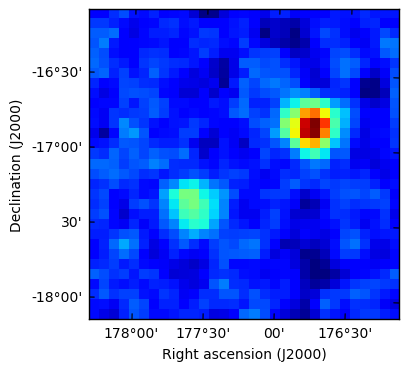

In [3]:
# Extracting WCS information from a data cube
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits

# Open example FITS cube and extract WCS header keywords
hdulist = fits.open("figures/data_cube.fits")
wcshead = wcs.WCS(hdulist[0].header)

# Pixel coordinates to be converted
x = 22
y = 19
z = 10

# Convert pixel coordinates to world coordinates
equ_coords = wcshead.wcs_pix2world(x, y, z, 0)

# Extract right ascension, declination and velocity
ra  = equ_coords[0] / 15.0;
dec = equ_coords[1]
vel = equ_coords[2] / 1000.0

# Print coordinates and plot channel map
print("Pixel coordinates: x = %i, y = %i, z = %i" % (x, y, z))
print("WCS coordinates:   RA = %.3f h, Dec = %.3f°, cZ = %.1f km/s" % (ra, dec, vel))

wcsheadcel = wcshead.celestial # only required if one wants to display celestial coordinates
fig = plt.figure()                       # Note: WCS in matplotlib only works if WCSAxes is installed!
fig.add_subplot(111, projection=wcsheadcel) # Activate these lines if you have WCSAxes on your system.
plt.imshow(hdulist[0].data[z], origin="lower", cmap="jet", interpolation="nearest")
plt.xlabel("Right ascension (J2000)")
plt.ylabel("Declination (J2000)")
plt.show()

##### Conversion between coordinate systems

Another common requirement is the conversion from one type of celestial coordinate to another, e.g. from J2000 equatorial coordinates to Galactic coordinates. In spherical geometry, this is simply achieved by rotating the ccordinate vector, $(\alpha, \beta)$, to derive the transformed coordinates, $(\alpha', \beta')$. For arbitrary celestial coordinate systems, this rotation can be expressed as

$$ \begin{eqnarray}
  \tan(\alpha_{0}' - \alpha') & = & \frac{\cos(\beta) \sin(\alpha - \alpha_{0})}{\sin(\beta) \cos(\beta_{0}) - \cos(\beta) \sin(\beta_{0}) \cos(\alpha - \alpha_{0})} , \\
  \sin(\beta') & = & \sin(\beta) \sin(\beta_{0}) + \cos(\beta) \cos(\beta_{0}) \cos(\alpha - \alpha_{0}) ,
\end{eqnarray} $$

where $\alpha_{0}$ and $\beta_{0}$ are the coordinates of the target coordinate system’s north pole (in source coordinates), and $\alpha_{0}'$ is the longitude of the source coordinate system’s north pole (in target coordinates). For a conversion from J2000 equatorial coordinates to Galactic coordinates the corresponding values are

$$ \begin{eqnarray}
  \alpha_{0}  & \approx & 192.8595^{\circ} \\
  \beta_{0}   & \approx & \phantom{0}27.1284^{\circ} \\
  \alpha_{0}' & \approx & 122.9320^{\circ} ,
\end{eqnarray} $$

while for a conversion from B1950 equatorial coordinates to Galactic coordinates we get

$$ \begin{eqnarray}
  \alpha_{0}  & = & 192.25^{\circ} \\
  \beta_{0}   & = & \phantom{0}27.40^{\circ} \\
  \alpha_{0}' & = & 123.00^{\circ} .
\end{eqnarray} $$

Note that in the latter case the numerical values are exact, as the definition of the Galactic coordinate system was originally based on the B1950 coordinate system. Similar to the examples above, conversion between any two coordinate systems (including ecliptic or Magellanic coordinates) can be carried out as long as the positions of the two north poles are known in both coordinate systems. A simple J2000-to-Galactic coordinate converter in Python is included below. This can easily be expanded to include additional coordinate systems.

In [ ]:
# Conversion between equatorial and Galactic coordinates
from math import sin, cos, asin, atan2, pi, degrees, radians

# Input
alpha = radians(10.6847929)     # RA (J2000) in deg
delta = radians(41.2690650)     # Dec (J2000) in deg

# Definition of north poles
a0 = radians(192.859496)        # RA of Galactic north pole in deg
d0 = radians( 27.128353)        # Dec of Galactic north pole in deg
l0 = radians(122.932000)        # Galactic longitude of J2000 north pole in deg

# Coordinate transformation
l = l0 - atan2(cos(delta) * sin(alpha - a0), sin(delta) * cos(d0) - cos(delta) * sin(d0) * cos(alpha - a0))
b = asin(sin(delta) * sin(d0) + cos(delta) * cos(d0) * cos(alpha - a0))

# Output
print("Input J2000:     (RA, Dec) = (%.4f°, %.4f°)" % (degrees(alpha), degrees(delta)))
print("Output Galactic: (l,  b)   = (%.4f°, %.4f°)" % (degrees(l) % 360.0, degrees(b)))

#### Redshift and radial velocity

The observed frequency of the HI emission of a source is another fundamental parameter that can be directly extracted from the observation. As stated in the [previous section](#Source-position-in-the-sky), the usual way of determining the spectral position of a source is to calculate the flux density-weighted **centroid** of the integrated spectrum along the spectral axis, hence

$$ \langle z \rangle = M_{1} = \frac{\sum_{z} z \, S(z)}{\sum_{z} S(z)} , $$

where the summation is over all spectral channels, $z$, covered by the source, and $S(z_{i})$ is the flux density at the corresponding channel. This is also known as the **first moment**, $M_{1}$, of the spectrum. Alternatively, one can fit a function, e.g. a Gaussian, to the spectral line and derive the centroid from the fit (see the section on <a href="#Model-fitting-to-spectral-line-profiles">Model fitting to spectral-line profiles</a> for details).

As discussed in the [previous section](#Source-position-in-the-sky), the WCS keywords in the header of a FITS data cube must be used to convert spectral channel numbers into physical coordinates such as frequency or velocity. HI data cubes are usually provided in units of either topocentric or barycentric frequency, as this is the way in which the data are recorded at the telescope. Prior to data analysis, the recorded frequency axis is often converted to more convenient [parameters](#Converting-between-frequency-and-velocity) and/or [reference systems](#Velocity-rest-frames), e.g. velocity in the Galactic standard-of-rest frame, as detailed below. HI surveys at higher redshift also often use redshift, $Z$, rather than frequency or velocity to characterise the spectral coordinate of sources. Redshift is defined as

$$ Z = \frac{f_{0}}{f} - 1 = \frac{\lambda}{\lambda_{0}} - 1 $$

where $f_{0}$ is the rest frequency of the observed emission line ($f_{0} \approx 1.42~\mathrm{GHz}$ in the case of the HI line), $f$ denotes the observed frequency of the emission, and the parameters $\lambda_{0}$ and $\lambda$ denote the respective wavelengths. The observed redshift, $Z_{\rm obs}$, is usually made up of several components, most notably the cosmological redshift, $Z_{\rm cos}$, caused by the “expansion” of the universe, the velocity redshift, $Z_{\rm pec}$, caused by the peculiar velocity of the source with respect to the observer, and the gravitational redshift, $Z_{\rm grav}$, caused the presence of gravitational fields. The gravitational redshift is negligible in most cases, so that we get

$$ 1 + Z_{\rm obs} = (1 + Z_{\rm cos}) \times (1 + Z_{\rm pec}) . $$

Note that the commonly encountered equation $Z_{\rm obs} = Z_{\rm cos} + Z_{\rm pec}$ is incorrect and just an approximation to the correct equation above for small redshifts of $Z_{\rm cos} \ll 1$ and $Z_{\rm pec} \ll 1$. Another factor that may need to be included is the redshift caused by the peculiar motion of the earth itself (and hence the observer) with respect to the CMB.

##### Converting between frequency and velocity

Under the assumption that the observed frequency shift (or redshift) of a source is caused by the Doppler effect due to the source&rsquo;s motion with respect to the observer, one can convert the frequency shift into a radial velocity. The special relativistic equation for conversion of the observed frequency, $f$, of a source into radial velocity, $v$, under the assumption that the object is moving towards or away from the observer reads

$$ \frac{v}{\mathrm{c}} = \frac{f_{0}^{2} - f^{2}}{f_{0}^{2} + f^{2}} $$

where $\mathrm{c}$ denotes the speed of light, and $f_{0}$ is the rest frequency of the observed line transition. This equation assumes that the observed redshift of a source is due to its relativistic velocity along the line of sight towards or away from the observer (relativistic Doppler effect). Note, however, that the observed redshift of distant sources is largely due to the &ldquo;cosmological expansion&rdquo; of space, not due to their velocity with respect to the observer. Hence, the above relation will not yield sensible results for sources at higher redshift; to characterise sources beyond redshift zero, frequency (or redshift) rather than velocity should be used. Also note that the equation above is only strictly valid for objects moving radially towards or away from the observer, and additional corrections would have to be applied if the object had a significant tangential velocity component as well.

There are two commonly used approximations to this equation which are accurate for small velocities of up to a few hundred kilometres per second. The so-called **optical definition** reads

$$ \frac{v_{\rm opt}}{\mathrm{c}} = \frac{f_{0}}{f} - 1 = Z $$

and the so-called **radio definition** is

$$ \frac{v_{\rm rad}}{\mathrm{c}} = 1 - \frac{f}{f_{0}} = \frac{Z}{1 + Z} . $$

The advantage of the radio definition is that equal increments in frequency correspond to equal increments in radial velocity. However, the radio definition is deprecated by the International Astronomical Union (IAU), and the optical defintion should be used instead. Note that $v_{\rm opt} \propto Z$ in the optical definition. Hence, $v_{\rm opt} = \mathrm{c} Z$ is often used in extragalactic surveys as a convenient representation of redshift in units of velocity, often referred to as “recession velocity”. However, the resulting values must not be mistaken for velocities, as the observed redshift of distant galaxies is dominated by the “expansion” of the universe and does not reflect their actual space velocity.

While the observed redshift is dominated by the “expansion” of the universe at higher redshifts, it is still possible to determine the relative radial velocity, $\Delta v_{\rm pec}$, between two objects under the assumption that they are at the same distance from the observer and thus experience the same cosmological redshift. In this case,

$$ \frac{v_{\rm pec}}{\mathrm{c}} = \frac{Z_{\rm obs} - Z_{\rm cos}}{1 + Z_{\rm cos}} $$

([<cite data-cite="2014MNRAS.442.1117D">Davis &amp; Scrimgeour 2014</cite>](http://adsabs.harvard.edu/abs/2014MNRAS.442.1117D)) and thus

$$ \frac{\Delta v_{\rm pec}}{\mathrm{c}} = \frac{\Delta Z_{\rm obs}}{1 + Z_{\rm cos}} , $$

where $\Delta Z_{\rm obs}$ is the difference between the observed redshifts of the two sources (assumed to be equal to the difference in their peculiar velocity redshifts), and $\mathrm{c}$ denotes the speed of light in vacuum. Note that this is the non-relativistic approximation for small peculiar velocities of $v_{\rm pec} \ll \mathrm{c}$; for large peculiar velocities the full, special-relativistic version of the equation must be used.

##### Velocity rest frames

The observed radial velocity of an astronomical object is subject to several projection effects such as the rotation and the orbital motion of the Earth, the motion of the Solar System about the Galactic centre, the motion of our Galaxy within the Local Group, etc. Hence, depending on the location of the object under study, conversion of its measured velocity into an appropriate reference system will be required.

A useful rest frame is the so-called barycentric rest frame which uses the **barycentre of the Solar System** as reference point and corrects for lower-order motions of the Earth–Moon system. It is the most commonly used reference system for objects located beyond the Local Group where “recession velocities” due to the expansion of the universe by far exceed peculiar motions found within the Local Group. In most cases, the spectra observed with a radio telescope are already provided in the barycentric frame. Note that the barycentric frame is often referred to as the heliocentric rest frame. The latter, however, uses the barycentre of the Sun instead of the Solar System barycentre as its reference point. The difference between barycentric and heliocentric velocities, however, is rather small and negligible in most cases. Conversion of topocentric velocities/frequencies (as seen by the telescope) into the barycentric rest frame requires knowledge of the geographic location of the telescope and the exact time of the observation. Hence, no general conversion formula can be given here.

For objects located in the Milky Way one usually uses the **local standard-of-rest** (LSR) frame as the reference for radial velocities. The LSR frame accounts for the peculiar motion of the Solar System of about $16.55~\mathrm{km \, s^{-1}}$ with respect to the regular rotation of the Galaxy. Radial velocities in the LSR frame, $v_{\rm LSR}$, can be calculated from barycentric velocities, $v_{\rm bar}$, via

$$ v_{\rm LSR} = v_{\rm bar} + 9 \cos(l) \cos(b) + 12 \sin(l) \cos(b) + 7 \sin(b) $$

where $l$ and $b$ are the Galactic longitude and latitude of the source, respectively ([<cite data-cite="1999AJ....118..337C">Courteau &amp; van den Bergh 1999</cite>](http://adsabs.harvard.edu/abs/1999AJ....118..337C)). This definition is the so-called &ldquo;dynamical defintion&rdquo; (also referred to as the LSRD) as specified by the IAU. There is an alternative &ldquo;kinematical definition&rdquo; (referred to as LSRK) which results in a slightly higher velocity of about $20~\mathrm{km \, s^{-1}}$ in the direction of $(\alpha, \delta) = (270^{\circ}, 30^{\circ})$ in the B1900 system. However, the LSRD definition is the one most commonly used and usually referred to as the LSR.

For the description of circumgalactic objects it is useful to also correct for the rotation velocity of our Milky Way of about $220~\mathrm{km \, s^{-1}}$. The corresponding reference frame, the so-called **Galactic standard-of-rest** (GSR) frame, is derived from the LSR frame via

$$ v_{\rm GSR} = v_{\rm LSR} + 220 \sin(l) \cos(b) . $$

For objects spread across the Local Group, a reference frame accounting for the motion of our Milky Way with respect to the Local Group barycentre would be more suitable. The corresponding radial velocities in the so-called **Local Group standard-of-rest** (LGSR) frame can be calculated from the GSR velocities via

$$ v_{\rm LGSR} = v_{\rm GSR} - 88 \cos(l) \cos(b) + 64 \sin(l) \cos(b) - 43 \sin(b) . $$

Note that this definition uses the apex vector calculated by [<cite data-cite="1999AJ....118..337C">Courteau &amp; van den Bergh (1999)</cite>](http://adsabs.harvard.edu/abs/1999AJ....118..337C) which differs slighly from the apex vector of [<cite data-cite="1996AJ....111..794K">Karachentsev &amp; Makarov (1996)</cite>](http://adsabs.harvard.edu/abs/1996AJ....111..794K) used by the [NASA/IPAC Extragalactic Database](https://ned.ipac.caltech.edu/). Overall, the solar apex with respect to the Local Group is not well defined, and the LGSR frame is therefore best avoided. In principal, one can correct the radial velocity for rest frames of even higher order in the hierarchy of the universe all the way up to the cosmic microwave background. The reference frames mentioned above, however, are the ones most frequently used.

A simple velocity converter in Python is included below.

In [ ]:
# Simple velocity calculator
from math import cos, sin, pi, radians

# Input
vbar  = -300.0               # Barycentric velocity in km/s
l     = radians(121.1744)    # Galactic longitude in deg
b     = radians(-21.5729)    # Galactic latitude in deg

# Conversion
vlsr  = vbar +   9.0 * cos(l) * cos(b) + 12.0 * sin(l) * cos(b) +  7.0 * sin(b)
vgsr  = vlsr + 220.0 * sin(l) * cos(b)
vlgsr = vgsr -  88.0 * cos(l) * cos(b) + 64.0 * sin(l) * cos(b) - 43.0 * sin(b)

# Output
print("Bar.: %.1f km/s" % vbar)
print("LSR:  %.1f km/s" % vlsr)
print("GSR:  %.1f km/s" % vgsr)
print("LGSR: %.1f km/s" % vlgsr)

#### Flux density, brightness temperature and column density

The peak **flux density** of a source is often simply taken as the maximum flux density value encountered, hence

$$ S_{\rm peak} = \max \limits_{i} \! \left[ S \! \left( \vec{p}_{i} \right) \right] . $$

Note, however, that this approach will result in a positive bias due to the contribution of noise to the measured signal (see the section on [Biases in source parameterisation](#Biases-in-source-parameterisation) below). This bias can be significant for faint sources near the detection limit of the data. Therefore, a better approach would be to fit a mathematical model to the source (e.g. a Gaussian) and then extract the peak flux density from the fit.

Flux densities are usually specified in units of Jansky, with $1~\mathrm{Jy} = 10^{-26}~\mathrm{W \, m^{-2} \, Hz^{-1}}$. In general, flux density, $S$, can be converted to **brightness temperature**, $T_{\rm B}$, via

$$ T_{\rm B} = \frac{\lambda^{2} S}{2 \mathrm{k_{b}} \Omega_{\rm PSF}} $$

where $\lambda$ is the wavelength of the emission, $\Omega_{\rm PSF}$ is the solid angle of the telecope beam, and $\mathrm{k_{B}}$ denotes the Boltzmann constant. For HI observations at redshift zero, where $\lambda \approx 21.1~\mathrm{cm}$, the equation can be simplified to

$$ \frac{T_{\rm B}}{\mathrm{K}} \approx \frac{606}{\theta_{a} \times \theta_{b}} \times \frac{S}{\mathrm{mJy}} $$

where $\theta_{a}$ and $\theta_{b}$ are the major and minor axis of the telescope beam (assumed to be Gaussian) in units of arcseconds. Under the additional assumption that the gas is optically thin ($\tau \ll 1$), we can directly derive the **HI column density**, $N_{\rm HI}$, from the brightness temperature via

$$ \frac{N_{\rm HI}}{\mathrm{cm^{-2}}} \approx \frac{1.823 \times 10^{18}}{\mathrm{K \, km \, s^{-1}}} \times \! \int \limits_{v_{1}}^{v_{2}} \! T_{\rm B} \mathrm{d} v $$

where $v$ denotes radial velocity, and the integration is over the entire spectral profile width of the emission.

#### Integrated flux and HI mass

The **total flux** of a source can be derived by summing the flux density values across the entire source mask and multiplying by the width, $\Delta z$, of a spectral channel:

$$ S_{\rm tot} = \Delta z \sum_{i} S \! \left( \vec{p}_{i} \right) . $$

However, as neighbouring pixels are usually correlated due to spatial oversampling of the data, we still need to divide by the solid angle of the point spread function (PSF) in order to derive the **integrated flux**:

$$ S_{\rm int} = \frac{S_{\rm tot}}{\Omega_{\rm PSF}} , $$

where

$$ \Omega_{\rm PSF} = \frac{\pi \, \theta_{a} \theta_{b}}{4 \ln(2)} \approx 1.13309 \, \theta_{a} \theta_{b} $$

is the solid angle of a two-dimensional **Gaussian PSF** with FWHM $\theta_{a} \times \theta_{b}$. For the purpose of flux correction, $\theta_{a}$ and $\theta_{b}$ must be specified in pixels rather than radians. Note that the size of the beam will generally change with frequency and that calculation of the integrated flux will become complicated in the case of non-Gaussian beams.

In practice, integrated flux is often specified in units of $\mathrm{Jy \, km \, s^{-1}}$, but $\mathrm{Jy \, Hz}$ is occasionally encountered as well and should be the preferred unit, as the former does not strictly constitute an integrated flux. Note that the accuracy of the resulting flux measurements depends on the accuracy of the source mask. If the mask is too small, then the measured flux will be too small as well. If the mask is too large, then the statistical uncertainty of the flux measurement will become unnecessarily large. Such issues can be minimised through careful **mask optimisation** prior to source parameterisation (see section on [Biases in source parameterisation](#Biases-in-source-parameterisation) below for details).

Under the assumption that the HI gas is optically thin and at redshift zero, the integrated flux of a source can be directly converted into an **HI mass**, $M_{\rm HI}$, if the distance, $d$, to the object is known:

$$ \frac{M_{\rm HI}}{M_{\odot}} = 0.236 \times \frac{S_{\rm int}}{\mathrm{Jy \, km \, s^{-1}}} \times \left( \! \frac{d}{\mathrm{kpc}} \! \right)^{\!2} . $$

#### Spectral line width

Measurement of the width of the HI spectral line profile can provide information about the microscopic and macroscopic motions of gas particles in the source. This, in turn, may give information about important physical parameters such as the kinetic temperature of the gas or the rotation velocity and dynamical mass of a galaxy. Several measures of line width are in use, the most common ones of which are the **standard deviation** ($\sigma$), the **full width at half maximum** ($w_{50}$) and the **full width at 20% of the maximum** ($w_{20}$).

One of the most basic ways of measuring the line width of sources across a large area on the sky is through calculation of the **second moment** of each spectrum in the data cube. The second moment is defined via the flux-weighted square of the radial velocity,

$$ M_{2} = \sqrt{\frac{\sum_{z} (z - M_{1})^{2} S(z)}{\sum_{z} S(z)}} , $$

where $S(z)$ is the flux density in channel $z$, and $M_{1}$ denotes the [first moment  &#10549;](#sof_sop:sec:moments) <!--\ref{sof_sop:sec:moments}--> of the spectrum. Hence, the second moment is equivalent to the standard deviation about $M_{1}$.

As measurement of the second moment is easily affected by noise, in particular where the HI emission is faint (e.g. near the edge of a source), more robust and sophisticated methods of measuring line width are often used. These include the fitting of model functions, e.g. a Gaussian function, to the spectral profile. Parameters such as $w_{50}$ or $w_{20}$ can then be derived from the fit and are less susceptible to the influence of noise.

In the case of extended sources, such as the Milky Way or high-velocity clouds, measurement of the profile width at individual locations across the source will enable estimates of the upper limit of the **kinetic gas temperature**. Under the assumptions that the gas can be approximated as an ideal gas and that the velocities of the gas particle follow a Maxwell&ndash;Boltzmann distribution, we can derive the kinetic temperature of the gas from the measured FWHM, $w_{50}$, of the spectral line:

$$ T_{\rm kin} \lesssim \frac{M_{\rm H} w_{50}^{2}}{8 \, \mathrm{k_{B}} \ln(2)} . $$

Here, $M_{\rm H}$ is the mass of a hydrogen atom and $\mathrm{k_{B}}$ denotes the Boltzmann constant. The measurement of $T_{\rm kin}$ constitutes an **upper limit** only, as non-thermal motions could have contributed to the observed line width, e.g. from turbulent motions or the superposition of multiple gas clouds along the line of sight.

#### Angular size and orientation

##### Ellipse fitting

For sources that are spatially resolved we might also be interested in some measure of the angular size and orientation of the source in the sky. One of the most basic methods to derive size information is to **fit an ellipse** to the integrated flux map of a source. This can be achieved through a basic moment analysis of the image. The second-order moments of the two-dimensional source image are defined as

$$ \begin{eqnarray}
    M_{xx} & = & \frac{\sum_{i} \, (x_{i} - \langle x \rangle)^{2} \, S(x_{i}, y_{i})}{\sum_{i} S(x_{i}, y_{i})} , \\
    M_{yy} & = & \frac{\sum_{i} \, (y_{i} - \langle y \rangle)^{2} \, S(x_{i}, y_{i})}{\sum_{i} S(x_{i}, y_{i})} , \\
    M_{xy} & = & \frac{\sum_{i} \, (x_{i} - \langle x \rangle) \, (y_{i} - \langle y \rangle) \, S(x_{i}, y_{i})}{\sum_{i} S(x_{i}, y_{i})} ,
\end{eqnarray} $$

where the summation is over all pixels of the source mask, and $\langle \vec{p} \rangle = (\langle x \rangle, \langle y \rangle)$ is the flux density-weighted centroid of the source (equivalent to the first-order moments in $x$ and $y$; see section on [Source position in the sky](#Source-position-in-the-sky)). Note that one could alternatively set $S(x_{i}, y_{i}) \equiv 1$ to assign equal weight to all pixels, in which case the geometric outline of the source mask would be fitted. With the second-order moments defined, we can then derive the major and minor axes, $a$ and $b$, as well as the position angle, $\phi$, of the source in the sky,

$$ \begin{eqnarray}
	a     & = & \sqrt{2 \left( M_{xx} + M_{yy} + \sqrt{(M_{xx} - M_{yy})^{2} + 4 M_{xy}^{2}} \right) } , \\
	b     & = & \sqrt{2 \left( M_{xx} + M_{yy} - \sqrt{(M_{xx} - M_{yy})^{2} + 4 M_{xy}^{2}} \right) } , \\
    \phi  & = & \frac{1}{2} \, \arctan \left( \! \frac{2 M_{xy}}{M_{xx} - M_{yy}} \! \right)
\end{eqnarray} $$

(see [<cite data-cite="1995MNRAS.272..821B">Banks, Dodd &amp; Sullivan 1995</cite>](http://adsabs.harvard.edu/abs/1995MNRAS.272..821B)). In the case of a source of Gaussian shape, $a$ and $b$ will correspond to twice the standard deviation, $\sigma$, of the Gaussian. Note that the major and minor axis will be specified in pixels and will need to be converted to angles in the sky. The position angle will be relative to the pixel grid (not the celestial coordinate system of the image) and defined in the mathematically correct sense, i.e. $\phi = 0^{\circ}$ points to the right rather than up. Conversions will need to be done to change the reference coordinate system or orientation of the position angle.

##### Fitting of an elliptical Gaussian

For sources that can be approximated by a **two-dimensional, elliptical Gaussian** function we can alternatively perform a Gaussian fit to derive the source size and orientation in the sky. A two-dimensional Gaussian function can be defined as

$$ G(x, y) = A \exp \left( \! -\frac{a^{2}(x,y)}{2 \sigma_{a}^{2}} - \frac{b^{2}(x,y)}{2 \sigma_{b}^{2}} \! \right) , $$

where $A$ is the amplitude of the Gaussian, $\sigma_{a}$ and $\sigma_{b}$ denote the standard deviation of the Gaussian along the major and minor axis, respectively, and the functions $a$ and $b$ are defined as

$$ \begin{eqnarray}
    a(x,y) & = & (x - x_{0}) \cos(\phi) & + & (y - y_{0}) \sin(\phi) , \\
    b(x,y) & = & (x - x_{0}) \sin(\phi) & - & (y - y_{0}) \cos(\phi) .
\end{eqnarray} $$

The parameter $\phi$ describes the position angle of the major axis with respect to the pixel coordinate grid, and $(x_{0}, y_{0})$ denotes the position of the centre of the Gaussian function. Thus, we end up with six free parameters of the fit overall: amplitude ($A$), position ($x_{0}$ and $y_{0}$), width ($\sigma_{a}$ and $\sigma_{b}$) and position angle ($\phi$).

The Python script below calculates and plots a two-dimensional, elliptical Gaussian function. It then attempts to fit an ellipse to the image, using the second-order moment analysis introduced above, to derive the size and orientation angle of the Gaussian. Lastly, the fitted ellipse is plotted on top of the original Gaussian. The resulting ellipse parameters should recover the input parameters of the Gaussian, i.e. a major axis of $a_{\rm ell} = 2 \sigma_{a}$, a minor axis of $b_{\rm ell} = 2 \sigma_{b}$ and a position angle of $\phi_{\rm ell} \equiv \phi_{\rm Gauss}~(\mathrm{mod}~180^{\circ})$, unless the Gaussian extends beyond the edges of the image, in which case the derived ellipse sizes will of course be too small.

Ellipse fit: a = 50.0, b = 30.0, phi = 20.0°


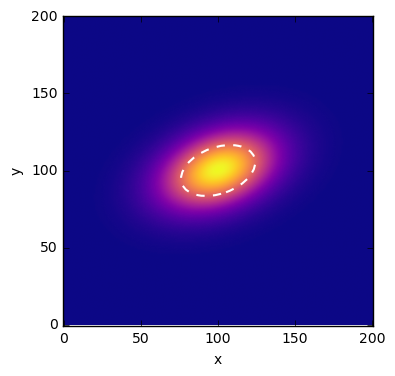

In [2]:
# Fitting an ellipse to a 2D elliptical Gaussian
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from numpy import empty
from math import sqrt, exp, sin, cos, atan2, pi

# Input parameters
(dx, dy) = 201, 201           # image size
(x0, y0) = 100.0, 100.0       # centre position
(sa, sb) = 25.0, 15.0         # widths
amp      = 1.0                # amplitude
phi      = 20.0 * pi / 180.0  # position angle

# Additional variables
(mxx, mxy, myy) = 0.0, 0.0, 0.0
sint = 0.0

# Create image
img = empty((dx, dy))

# Generate Gaussian function
for x in range(dx):
    for y in range(dy):
        a = (x - x0) * cos(phi) + (y - y0) * sin(phi)
        b = (x - x0) * sin(phi) - (y - y0) * cos(phi)
        img[y][x] = amp * exp(-(a * a / (2.0 * sa * sa)) - (b * b / (2.0 * sb * sb)))

# Calculate second-order moments for ellipse fit
for x in range(dx):
    for y in range(dy):
        mxx += (x - x0) * (x - x0) * img[y][x]
        mxy += (x - x0) * (y - y0) * img[y][x]
        myy += (y - y0) * (y - y0) * img[y][x]
        sint += img[y][x]
mxx /= sint; mxy /= sint; myy /= sint

# Determine ellipse parameters
emaj = sqrt(2.0 * (mxx + myy + sqrt((mxx - myy) * (mxx - myy) + 4.0 * mxy * mxy)))
emin = sqrt(2.0 * (mxx + myy - sqrt((mxx - myy) * (mxx - myy) + 4.0 * mxy * mxy)))
epos = (0.5 * atan2(2.0 * mxy, mxx - myy))

# Print result of ellipse fit
print("Ellipse fit: a = %.1f, b = %.1f, phi = %.1f°" % (emaj, emin, (180.0 * epos / pi)))

# Plot image
plt.imshow(img, origin="lower", cmap="plasma", interpolation="bicubic")
plt.xlabel("x")
plt.ylabel("y")
axes = plt.gca()
axes.add_patch(Ellipse((x0, y0), emaj, emin, (180.0 * epos / pi), edgecolor="white", fill=False, linewidth=1.5, linestyle="dashed", antialiased=True))
plt.show()

### Creation of advanced data products

#### Moment maps<a id='sof_sop:sec:moments'></a><!--\label{sof_sop:sec:moments}-->

Among the most commonly required data products are moment maps of the sources detected in a data cube. Moment maps condense the spectral information of the cube into a two-dimensional image that can then be analysed further. The **zeroth moment** of the cube simply integrates over the spectral axis to create an integrated flux map,

$$ M_{0}(x, y) = \Delta v \sum_{z} S(x, y, z) , $$

where $\Delta v$ is the velocity width of a spectral channel (assumed to be constant across the spectral extent of the source), $S$ is the measured flux density, and the summation is over all spectral channels, $z$, covered by the source. If a source mask is unavailable for the purpose of defining the spectral boundaries of the emission, a flux threshold can instead be used, although the result will not be optimal in this case. Fluxes in the moment-0 map are usually specified in $\mathrm{Jy \, km \, s^{-1}}$, but can be converted to HI column density as specified in the section on [Flux density, brightness temperature and column density](#Flux-density,-brightness-temperature-and-column-density). Similarly, the **first moment**
is defined as the flux density-weighted velocity at each pixel of the map,

$$ M_{1}(x, y) = \frac{\sum_{z} v(z) \, S(x, y, z)}{\sum_{z} S(x, y, z)} , $$

where $v(z)$ is the velocity associated with spectral channel $z$, and the summation is again over all spectral channels covered by the source. Thus, the moment-1 image will show the radial velocity centroid of the HI emission at each pixel of the map. Alternatively, if $v(z)$ is unknown, $z$ can be used instead to derive the first moment in units of channel number rather than velocity. Lastly, we can calculate the **second moment** to derive a map of spectral line widths,

$$ M_{2}(x, y) = \sqrt{\frac{\sum_{z} [v(z) - M_{1}(x, y)]^{2} \, S(x, y, z)}{\sum_{z} S(x, y, z)}} . $$

The moment-2 image shows the standard deviation about the first moment and thus encodes the velocity dispersion of the gas in each pixel of the map. 

#### Peak flux density map

Another convenient data product, particularly for display purposes, is the **peak flux density** map. It is simply created by displaying in each pixel the highest flux density encountered along the spectral axis,

$$ S_{\rm max}(x, y) = \max \limits_{z}[S(x, y, z)] . $$

The advantage of the peak flux density map is that it is capable of revealing even faint sources within the data cube without requiring a-priori knowledge of the sources’ location, while for a high-contrast moment-zero image accurate source masks would be required, as the noise would increase with the square root of the number of channels added.

A short Python script that calculates and displays the three moments and the peak flux density map of the example data cube is included below. Note that this is a greatly simplified version that does not utilise source masks, but instead uses a simple, user-defined flux threshold to generate moment maps. Moreover, all maps in the example are generated from scratch by looping over all three dimensions of the data cube multiple times. While this may be an efficient method in compiled programming languages like C++, it will be far too slow in Python for large data cubes. Instead, special libraries such as NumPy should be used to efficiently handle large data arrays in Python.

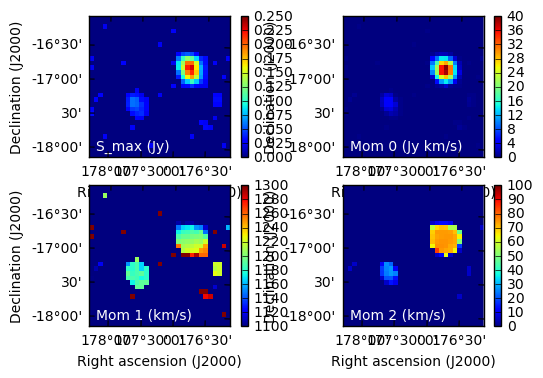

In [4]:
# Generating moment and peak flux density maps from a data cube
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from math import sqrt

def genmomaps(incubus = '', maskcube = '', threshold = 0.025, minmaxpeak = [0., 0.1], minmaxmom0 = [0.,1.], minmaxmom1 = [0., 200.], minmaxmom2 = [0., 50.]):
    """
    Generating moment and peak flux density maps from a data cube
    incubus (string) : Input data cube
    maskcube (string): Mask data cube 
    threshold (float): Additional threshold, below which pixels are flagged
    minmaxpeak (list): Minum and maximum for colour scale in peak flux map
    minmaxmom0 (list): Minimum and maximum for colour scale in Moment-0 map
    minmaxmom1 (list): Minimum and maximum for colour scale in Moment-1 map
    minmaxmom2 (list): Minimum and maximum for colour scale in Moment-2 map    
    """    
    # Check if mask exists and read in mask
    if maskcube != '':
        hdulist = fits.open(maskcube)
        maskdata = hdulist[0].data      
    
    # Open example FITS cube and extract WCS header keywords and data
    hdulist = fits.open(incubus)
    wcshead = wcs.WCS(hdulist[0].header)
    scidata = hdulist[0].data
    
    # Read cube dimensions and create arrays for maps
    nz, ny, nx = scidata.shape
    
    if maskcube == '':
        maskdata = np.ones((nz,ny,nx), dtype=float)
    
    for x in range(nx):
        for y in range(ny):
            for z in range(nz):
                if scidata[z][y][x] < threshold:
                    maskdata[z][y][x] = 0.

    mom0 = [[0 for x in range(nx)] for y in range(ny)]
    mom1 = [[0 for x in range(nx)] for y in range(ny)]
    mom2 = [[0 for x in range(nx)] for y in range(ny)]
    peak = [[0 for x in range(nx)] for y in range(ny)]

    # Convert channel numbers to velocity using WCS
    velo = [0 for z in range(nz)]
    for z in range(nz):
        equ_coords = wcshead.wcs_pix2world(0, 0, z, 0)
        velo[z] = equ_coords[2] / 1000.0
    dv = abs(velo[1] - velo[0])

    # Create moment-0 and peak flux density maps
    for x in range(nx):
        for y in range(ny):
            mom0[y][x] = 0.0;
            peak[y][x] = -10000000.0;
            for z in range(nz):
                if scidata[z][y][x] > peak[y][x] and maskdata[z][y][x]: peak[y][x] = scidata[z][y][x]
                if scidata[z][y][x] > threshold and maskdata[z][y][x]: mom0[y][x] += scidata[z][y][x]

    # Create moment-1 map
    for x in range(nx):
        for y in range(ny):
            mom1[y][x] = 0.0;
            for z in range(nz):
                if scidata[z][y][x] > threshold and maskdata[z][y][x]: mom1[y][x] += velo[z] * scidata[z][y][x]
            if mom0[y][x] > 0.0: mom1[y][x] /= mom0[y][x]

    # Create moment-2 map
    for x in range(nx):
        for y in range(ny):
            mom2[y][x] = 0.0;
            for z in range(nz):
                if scidata[z][y][x] > threshold and maskdata[z][y][x]: 
                    mom2[y][x] += (velo[z] - mom1[y][x]) * (velo[z] - mom1[y][x]) * scidata[z][y][x]
            if mom0[y][x] > 0.0: mom2[y][x] = sqrt(mom2[y][x] / mom0[y][x])

    # Lastly, multiply moment-0 map with dv
    for x in range(nx):
        for y in range(ny):
            mom0[y][x] *= dv

    wcsheadcel = wcshead.celestial # only required if one wants to display celestial coordinates
    fig = plt.figure()                       # Note: WCS in matplotlib only works if WCSAxes is installed!
    fig.add_subplot(221, projection=wcsheadcel) # Activate these lines if you have WCSAxes on your system.
    
    # Plot all maps
    plt.imshow(peak, origin="lower", cmap="jet", interpolation="nearest", vmin=minmaxpeak[0], vmax=minmaxpeak[1])
    plt.colorbar()
    plt.xlabel("Right ascension (J2000)")
    plt.ylabel("Declination (J2000)")
    plt.text(1, 1, "S_max (Jy)", color="white")
    fig.add_subplot(222, projection=wcsheadcel) # Activate these lines if you have WCSAxes on your system.
    plt.imshow(mom0, origin="lower", cmap="jet", interpolation="nearest", vmin=minmaxmom0[0], vmax=minmaxmom0[1])
    plt.colorbar()
    plt.xlabel("Right ascension (J2000)")
    plt.ylabel("Declination (J2000)")
    plt.text(1, 1, "Mom 0 (Jy km/s)", color="white")
    
    fig.add_subplot(223, projection=wcsheadcel) # Activate these lines if you have WCSAxes on your system.
    plt.imshow(mom1, origin="lower", cmap="jet", interpolation="nearest", vmin=minmaxmom1[0], vmax=minmaxmom1[1])
    plt.colorbar()
    plt.xlabel("Right ascension (J2000)")
    plt.ylabel("Declination (J2000)")
    plt.text(1, 1, "Mom 1 (km/s)", color="white")
    fig.add_subplot(224, projection=wcsheadcel) # Activate these lines if you have WCSAxes on your system.
    plt.imshow(mom2, origin="lower", cmap="jet", interpolation="nearest", vmin=minmaxmom2[0], vmax=minmaxmom2[1])
    plt.colorbar()
    plt.xlabel("Right ascension (J2000)")
    plt.ylabel("Declination (J2000)")
    plt.text(1, 1, "Mom 2 (km/s)", color="white")
    plt.show()

    
genmomaps(incubus = 'figures/data_cube.fits', maskcube = '', threshold = 0.025, 
          minmaxpeak = [0., 0.25], minmaxmom0 = [0.,40.], minmaxmom1 = [1100., 1300.], minmaxmom2 = [0., 100.])


#### Simple source masks: Miriad example

The importance of source masks has been pointed out above. Here, we include a minimalistic example of how to derive an image mask using the Miriad software suite. We read in a fits file containing an observation of UGCA 105, a gas-rich dwarf galaxy. Subsequently, we convolve the image with a Gaussian to derive the image mask from the resulting data cube by clipping, using the task maths. 

The reason for this filtering is that we know that most emission in the cube is of extended nature, well extending the original beam size of $40^{\prime\prime}$. By convolving the data cube with a Gaussian of $60^{\prime\prime}$ we hence enhance the signal-to-noise ratio. 

This becomes clearer in a thought experiment. 

Imagine convolving a data cube with statistically independent pixels and uniform rms noise not with a Gaussian but with a (not normalised) box function, the box containing n pixels. Then, as the result is simply a sum over n pixels per resulting pixel, the rms is proportional to the square root of the number of pixels. Let us assume that the source is as extended as possible, i.e. the intensity is constant across the field. Then, the signal increases by the number of pixels and hence the signal-to-noise ratio decreases by the square root of the number of pixels. If the source is the opposite of extended, i.e. a single pixel, the sum stays at the value of the single pixel and the signal-to-noise ratio decreases by the square root of the number of pixels contained in the boxcar. In reality the maths is a bit more complicated but the result stays basically.

Filtering (convolving) a cube to enhance the signal-to-noise ratio to find sources is a valid technique. However, the optimal kernel depends on the source structure and it might vary over an image. Whether source finding by clipping (creating a mask is the same as source finding) should be done at high or low resolution can be determined a-priori only by knowing more about the source structure. We know the optical extent of UGCA 105, we know that it is gas-rich, and we know that the gas in gas-rich galaxies entends over the optical disk. We hence infer that we best filter at low resolution in the given case.

Handling interferometric radio data, we encounter an additional trap: filtering in the image domain is equivalent to tapering in the uv-domain. In other words, visibilities get downweighted by filtering (the larger the filter the more), and the result is that the rms increases overproportionally.

Modern source finders have to take into account all these facts and if they are based on a filtering and clip algorithm, what is mostly done is to apply multiple filters by default. In a second step, source candidates are often de-selected employing statistical means or a second prior knowledge.

In our case we make use of the Miriad task mafia, with which we can count pixels on "islands". If an island contains less than a certain number of pixels, we de-select the island. This again relies on the fact that we expect contiguous, large emitting fields to be observed in this nearby galaxy. Finally, we assume that detections have a certain line width, and we enforce an island to be real only if it overlaps with an island in a neighbouring channel.

In [5]:
import os
def getmaskmir(incubus = '', outcube = '', fwhm = '40', clip = '0.00175', minpix = '75', images = '1,100'):
    """
    Create a mask using miriad tasks
    
    Parameters:
    incubus (string): Input data cube to be masked
    outcube (string): Output data cube to be masked
    fwhm (string)   : Full-width-at-half-maximum of Gaussian to convolve original cube with
    clip (string)   : Clip level to create mask
    minpix (string) : Minimum number of pixels in islands
    images (string) : Planes to include in mask (all others flagged)
    """    

    print '# Executing MIRIAD commands'

    if incubus == '':
        raise Exception('Ey, give me an input cube')
    if outcube == '':
        raise Exception('Ey, give me an output cube')
  
    # Delete file (directory) if it exists
    if os.path.exists('bla_incubus'): shutil.rmtree('bla_incubus')

    # Read in fits file    
    run_fits = Run('fits in='+incubus+' out=bla_incubus op=xyin')

    # Convolve
    if os.path.exists('bla_convolved'): shutil.rmtree('bla_convolved')
    run_convol = Run('convol map=bla_incubus out=bla_convolved fwhm='+fwhm)

    # Clip
    if os.path.exists('bla_clipped'): shutil.rmtree('bla_clipped')
    run_maths = Run('maths exp="<bla_incubus>" out=bla_clipped mask=<bla_convolved>.gt.'+clip)

    # Exclude islands smaller than n pixels
    run_mafia = Run('mafia in=bla_clipped options=mask pixels=' + minpix)

    # Exclude islands isolated in v
    run_mafia = Run('mafia in=bla_clipped options=3dim,blink,mask')

    # Exclude Milky Way
    run_immask = Run('immask in=bla_clipped flag=true logic=and region=images('+images+')')

    # Create binary mask               
    if os.path.exists('bla_binary_masked'): shutil.rmtree('bla_binary_masked')
    run_maths = Run('maths exp=<bla_clipped>*0+1 out=bla_binary_masked')

    # Replace masked pixels with 0s
    if os.path.exists('bla_binary'): shutil.rmtree('bla_binary')            
    run_imblr = Run('imblr in=bla_binary_masked out=bla_binary')
    
    # Write fits cube
    if os.path.exists(outcube): os.remove(outcube)
    run_fits = Run('fits in=bla_binary out='+outcube+' op=xyout')

    # Clean up
    shutil.rmtree('bla_incubus')
    shutil.rmtree('bla_convolved')
    shutil.rmtree('bla_clipped') 
    shutil.rmtree('bla_binary_masked') 
    shutil.rmtree('bla_binary')
    
    print '# Done'

getmaskmir(incubus = 'figures/UGCA105cube.fits', outcube = 'figures/UGCA105_mask.fits', images = '8,55')

# Executing MIRIAD commands
fits in=figures/UGCA105cube.fits out=bla_incubus op=xyin
convol map=bla_incubus out=bla_convolved fwhm=40
maths exp="<bla_incubus>" out=bla_clipped mask=<bla_convolved>.gt.0.00175
mafia in=bla_clipped options=mask pixels=75
mafia in=bla_clipped options=3dim,blink,mask
immask in=bla_clipped flag=true logic=and region=images(8,55)
maths exp=<bla_clipped>*0+1 out=bla_binary_masked
imblr in=bla_binary_masked out=bla_binary
fits in=bla_binary out=figures/UGCA105_mask.fits op=xyout
# Done


It is clear, however, that using a software package as above a lot of overhead is created by input and output to the mass storage device. In an automated pipeline dealing with larger amounts of data, it is a requirement to create a mask kept in memory. This is, however, a discussion to be continued at a different place.

Let us look how the moment maps turn out if we use the mask instead of a threshold:

In [6]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
import math
import os

def genmomaps_tofits(incubus = '', maskcube = '', peakmapname = '', totinsname = '', mom1name = '', 
                     mom2name = '', threshold = 0.025, minmaxpeak = [0., 0.1], minmaxmom0 = [0.,1.], 
                     minmaxmom1 = [0., 200.], minmaxmom2 = [0., 50.]):
    """
    Generate moment maps and write into fits files
    
    incubus (string)    : Input data cube
    maskcube (string)   : Mask data cube 
    peakmapname (string): Name of output peak intensity map
    totinsname (string) : Name of total-intensity map
    mom1name (string)   : Name of moment-1 map
    mom2name (string)   : Name of moment-2 map
    threshold (float)   : Additional threshold, below which pixels are flagged

    """
    # Check if mask exists and read in mask
    if maskcube != '':
        hdulist = fits.open(maskcube)
        maskdata = hdulist[0].data      
    
    # Open example FITS cube and extract WCS header keywords and data
    hdulist = fits.open(incubus)
    wcshead = wcs.WCS(hdulist[0].header)
    scidata = hdulist[0].data
    
    # Read cube dimensions and create arrays for maps
    nz, ny, nx = scidata.shape
    
    if maskcube == '':
        maskdata = np.ones((nz,ny,nx), dtype=float)
    
    for x in range(nx):
        for y in range(ny):
            for z in range(nz):
                if scidata[z][y][x] < threshold:
                    maskdata[z][y][x] = 0.

    mom0 = [[0 for x in range(nx)] for y in range(ny)]
    mom1 = [[0 for x in range(nx)] for y in range(ny)]
    mom2 = [[0 for x in range(nx)] for y in range(ny)]
    peak = [[0 for x in range(nx)] for y in range(ny)]

    # Convert channel numbers to velocity using WCS
    velo = [0 for z in range(nz)]
    for z in range(nz):
        equ_coords = wcshead.wcs_pix2world(0, 0, z, 0)
        velo[z] = equ_coords[2] / 1000.0
    dv = abs(velo[1] - velo[0])

    # Create moment-0 and peak flux density maps
    if peakmapname != '':
        for x in range(nx):
            for y in range(ny):
                mom0[y][x] = 0.0;
                peak[y][x] = -10000000.0;
                for z in range(nz):
                    if scidata[z][y][x] > peak[y][x] and maskdata[z][y][x]: peak[y][x] = scidata[z][y][x]
                    if scidata[z][y][x] > threshold and maskdata[z][y][x]: mom0[y][x] += scidata[z][y][x]
                if peak[y][x] == -10000000.0:
                    peak[y][x] = float('nan')

    # Create moment-1 map
    for x in range(nx):
        for y in range(ny):
            mom1[y][x] = 0.;
            for z in range(nz):
                if scidata[z][y][x] > threshold and maskdata[z][y][x]: mom1[y][x] += velo[z] * scidata[z][y][x]
            if math.isnan(peak[y][x]): mom1[y][x] = peak[y][x]
            if mom0[y][x] > 0.0: mom1[y][x] /= mom0[y][x]

    # Create moment-2 map
    for x in range(nx):
        for y in range(ny):
            mom2[y][x] = 0.0;
            for z in range(nz):
                if scidata[z][y][x] > threshold and maskdata[z][y][x]: mom2[y][x] += (velo[z] - mom1[y][x]) * (velo[z] - mom1[y][x]) * scidata[z][y][x]
            if mom0[y][x] > 0.0: mom2[y][x] = math.sqrt(mom2[y][x] / mom0[y][x])
            if math.isnan(peak[y][x]): mom2[y][x] = peak[y][x]

    # Lastly, multiply moment-0 map with dv
    for x in range(nx):
        for y in range(ny):
            mom0[y][x] *= dv
    
    # Get header and make a twodimensional data set with same coordinate frame
    hdulist[0].header.pop('NAXIS3', 0)
    hdulist[0].header.pop('NAXIS4', 0)
    hdulist[0].header.pop('CTYPE3', 0)
    hdulist[0].header.pop('CTYPE4', 0)
    hdulist[0].header.pop('CRPIX3', 0)
    hdulist[0].header.pop('CRPIX4', 0)
    hdulist[0].header.pop('CRVAL3', 0)
    hdulist[0].header.pop('CRVAL4', 0)
    hdulist[0].header.pop('CDELT3', 0)
    hdulist[0].header.pop('CDELT4', 0)
    hdulist[0].header.pop('DATAMIN', 0)
    hdulist[0].header.pop('DATAMAX', 0)
    hdulist[0].header.set('NAXIS', 2)
    
    # Write peak intensity map
    if peakmapname != '':
        hdulist[0].header.set('BUNIT', 'JY/BEAM')
        hdulist[0].data = peak
        if os.path.exists(peakmapname): os.remove(peakmapname)
        hdulist.writeto(peakmapname)

    # Write total intensity map
    if totinsname != '':
        hdulist[0].header.set('BUNIT', 'JY.KM/S')
        hdulist[0].data = mom0
        if os.path.exists(totinsname): os.remove(totinsname)
        hdulist.writeto(totinsname)

    # Write velocity field
    if mom1name != '':
        hdulist[0].header.set('BUNIT', 'KM/S')
        hdulist[0].data = mom1
        if os.path.exists(mom1name): os.remove(mom1name)
        hdulist.writeto(mom1name)

            # Write total intensity map
    if mom2name != '':
        hdulist[0].header.set('BUNIT', 'KM/S')
        hdulist[0].data = mom2
        if os.path.exists(mom2name): os.remove(mom2name)
        hdulist.writeto(mom2name)

genmomaps_tofits(incubus = 'figures/UGCA105cube.fits', maskcube = 'figures/UGCA105_mask.fits', peakmapname = 'figures/UGCA105_peak.fits', 
                 totinsname = 'figures/UGCA105_m0.fits', 
                 mom1name = 'figures/UGCA105_m1.fits', mom2name = 'figures/UGCA105_m2.fits', 
                 threshold = -1000.)

<IPython.core.display.Javascript object>


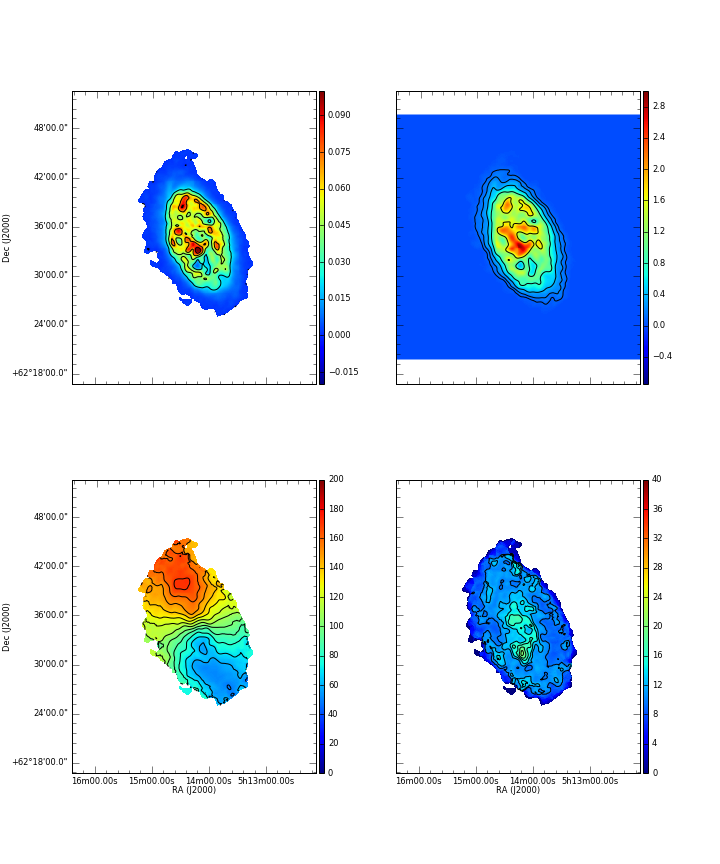

<IPython.core.display.Javascript object>


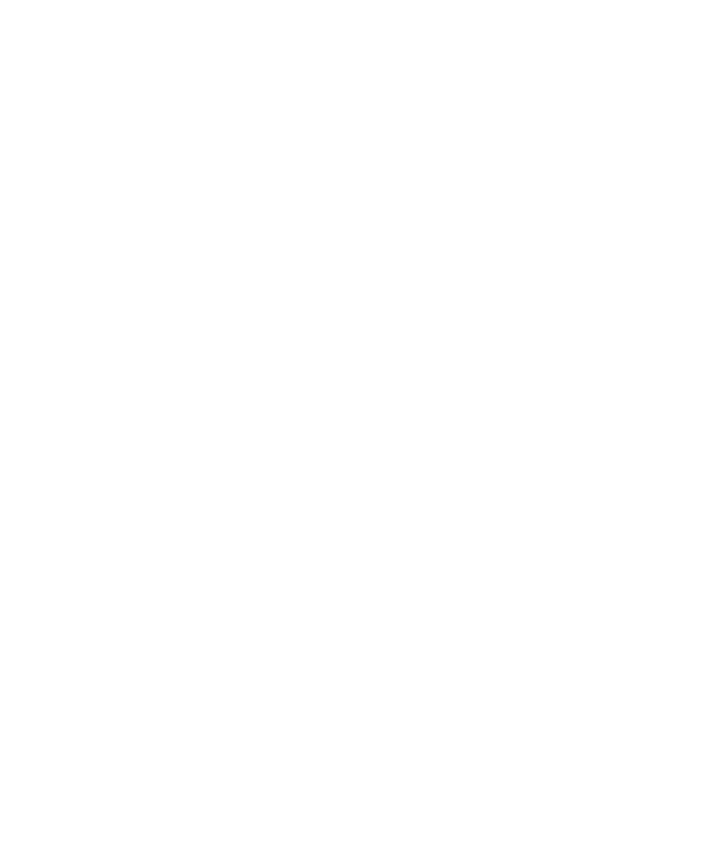

In [10]:
import aplpy
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits

def plotmomaps_aplpy(peakmapname = '', totinsname = '', mom1name = '', mom2name ='',
                     minmaxpeak = [0., 0.1], minmaxtotins = [0.,1.], 
                     minmaxmom1 = [0., 200.], minmaxmom2 = [0., 50.], peakmaplevs = 5, 
                     totinslevs = 5, mom1levs = 5, mom2levs = 5):
    """
    Use aplpy to plot several maps to inspect data
    
    The maps are in principle arbitrary but given names here to indicate the purpose of this script.
    
    peakmapname (string)     : Name of peak flux density map
    totinsname (string)      : Name of total intensity map
    mom1name (string)        : Name of velocity field
    mom2name (string)        : Name of moment-2 map
    minmaxpeak (list)        : Minum and maximum for colour scale in peak flux map
    minmaxmom0 (list)        : Minimum and maximum for colour scale in Moment-0 map
    minmaxmom1 (list)        : Minimum and maximum for colour scale in Moment-1 map
    minmaxmom2 (list)        : Minimum and maximum for colour scale in Moment-2 map
    peakmaplevs (int or list): Either explicit contour levels or number of contour levels for peak flux density map
    totinslevs (int or list) : Either explicit contour levels or number of contour levels for total intensity map
    mom1levs (int or list)   : Either explicit contour levels or number of contour levels for velocity field
    mom2levs (int or list)   : Either explicit contour levels or number of contour levels for moment-2 map
    """
    
    fig = plt.figure(figsize=(10,12))

    border = 0.1
    dx = (1.0-3*border)/float(2)
    dy = (1.0-3*border)/float(2)

    
    names = [peakmapname, totinsname, mom1name, mom2name]
    vmins = [minmaxpeak[0], minmaxtotins[0], minmaxmom1[0], minmaxmom2[0]]
    vmaxs = [minmaxpeak[1], minmaxtotins[1], minmaxmom1[1], minmaxmom2[1]]
    levs  = [peakmaplevs, totinslevs, mom1levs, mom2levs]
    
    appfigs = []
    for j in range(2):
        for i in range(2):
            appfig = aplpy.FITSFigure(names[j*2+i], figure = fig, subplot=[(i+1)*border+i*dx,1.0-(j+1)*(border+dy),dx,dy])
            if i > 0:
                appfig.hide_yaxis_label()
                appfig.hide_ytick_labels()
            if j < 1:
                appfig.hide_xaxis_label()
                appfig.hide_xtick_labels()
            appfig.show_colorscale(vmin = vmins[j*2+i], vmax = vmaxs[j*2+i])
            appfig.add_colorbar()
            appfig.show_contour(colors = 'black', levels = levs[2*j+i])

            appfig.axis_labels.set_font(size='small')
            appfig.axis_labels.set_xpad(0.03)
            appfig.axis_labels.set_ypad(0.03)
            appfig.tick_labels.set_font(size='small')
            appfig.ticks.set_color('black')
            appfig.colorbar.set_font(size='small')
            appfig.colorbar.set_width(0.075)
            appfig.colorbar.set_pad(0.03)
            appfigs.append(appfig)

    plt.show()
#    plt.canvas.draw()

plotmomaps_aplpy(peakmapname = 'figures/UGCA105_peak.fits', totinsname = 'figures/UGCA105_m0.fits', 
                 mom1name = 'figures/UGCA105_m1.fits', mom2name = 'figures/UGCA105_m2.fits',
                 minmaxpeak = [-0.02, 0.1], minmaxtotins = [-0.75, 3.], minmaxmom1 = [0., 200.], 
                 minmaxmom2 = [0., 40.], peakmaplevs = 5, totinslevs = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2], 
                 mom1levs = list(np.arange(40.,180.,10.)), mom2levs = list(np.arange(10.,30.,2.)))

#### Slices through the data cube

A data cube is a threedimensional structure. Some programs can display a data cube as a threedimensional structure, and this can be helpful to interpret the data at hand.

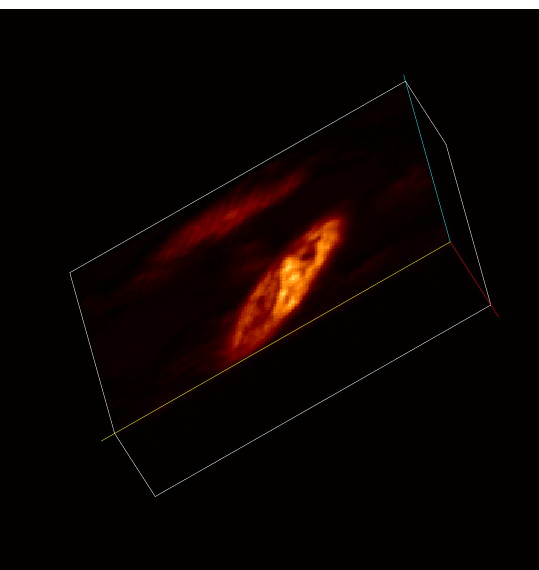

In [11]:
from wand.image import Image as WImage
img = WImage(filename='figures/UGCA105cube.fits.eps')
img

<div align="center">Visualisation of a data cube of an HI observation of the galaxy UGCA 105. The yellow axis denotes declination, blue axis right ascension, red axis velocity.
</div>

##### Data cube images

To avoid the complication of interpreting 3-D data all in one go, however, one can resort to looking at the intersection of planes in a data cube. The simplest realisation is to inspect the planes of a data cube itself.

<IPython.core.display.Javascript object>


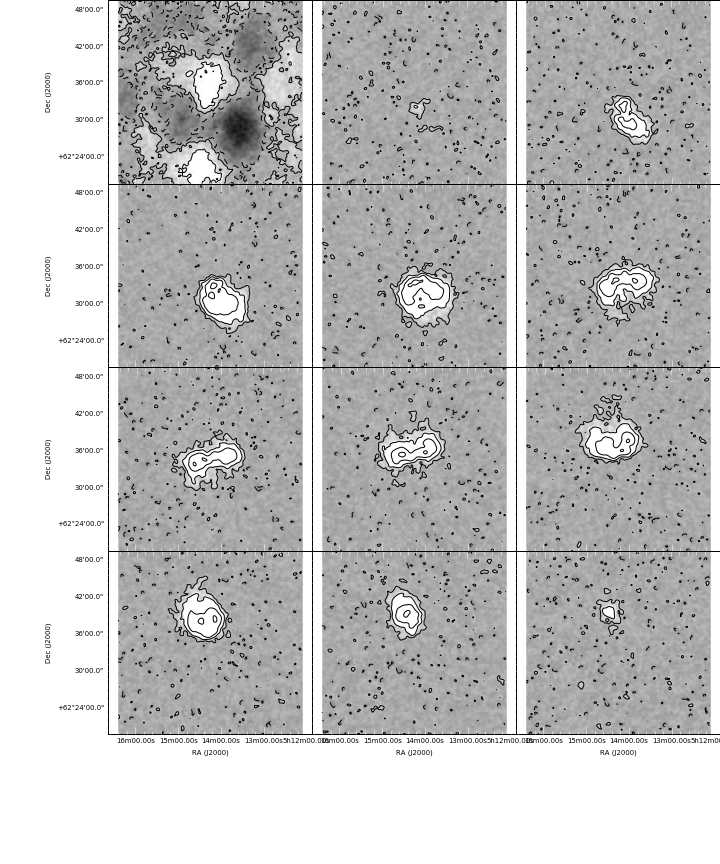

<IPython.core.display.Javascript object>


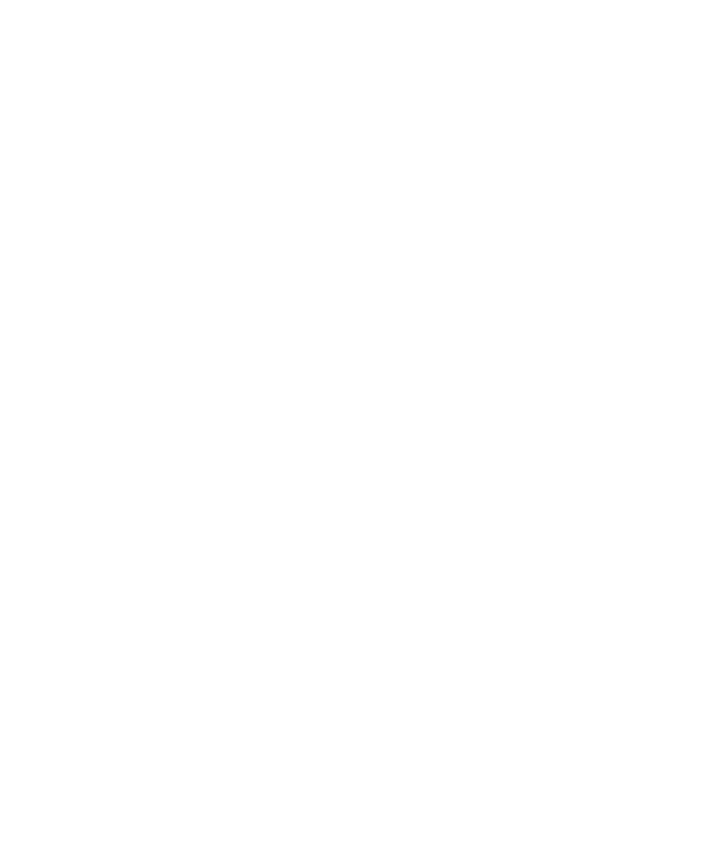

In [12]:
import aplpy
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits

def plotcube(incubus = '', border = 0.15, nx = 3, ny = 4, level = 0.001, factor = 4, contours = 5, 
             ming = -0.01, mang = 0.005):
    """
    
    Plot a cube
    
    border (float): border to bottom and left in relative coordinates (1: entire width)
    nx (int): number of images in x-direction
    ny (int): number of images in y-direction
    level (float): lowest contour level, will draw -level, level, level*factor, level*factor*factor, ...
    factor (float): see above
    contours: (int): number of contour levels
    ming (float): minimum for greyscale map
    mang (float): maximum for greyscale map
    """
    
    # Sizes of panels in x and y
    dx = (1.0-border)/float(nx)
    dy = (1.0-border)/float(ny)

    # Just read the number of channels (maybe better to use the header)
    channels = fits.open(incubus)[0].data.shape[0]

    channelsep = channels/(nx*ny) # channel increment for plotting

    contlevels = [-level]
    
    for i in range(contours-1):
        contlevels.append(level*pow(factor,i))
    
    fig = plt.figure(figsize=(10,12))
    appfigs = []

    for j in range(ny):
        for i in range(nx):
            appfig = aplpy.FITSFigure(incubus, figure = fig, slices=[((i+1)+j*nx)*channelsep], 
                                        subplot=[border+i*dx,1.0-(j+1)*dy,dx,dy])
            if i > 0:
                appfig.hide_yaxis_label()
                appfig.hide_ytick_labels()
            if j < ny - 1:
                appfig.hide_xaxis_label()
                appfig.hide_xtick_labels()
            appfig.axis_labels.set_font(size='x-small')
            appfig.tick_labels.set_font(size='x-small')
            appfigs.append(appfig)

    for i in range(len(appfigs)):
        appfigs[i].show_grayscale(vmin=ming, vmax=mang)
        appfigs[i].show_contour(colors = 'black', levels = contlevels)
    plt.show()
    
plotcube(incubus = 'figures/UGCA105cube.fits')

##### PV-diagrams

The other, often used to reduce the data amount that the eye has to digest, is the position-velocity diagram (PV-diagram). Along a line on the sky spectra are drawn in equidistant spaces, such that one axis of the PV-diagram is a spatial distance, the distance along the line, with some origin, the other is frequency or velocity. Hence, a PV-diagram is simply another slice through a data cube, geometrically equivalent to single image planes. A PV-diagram is meaningful in combination with the line(s) plotted on some image of the source.

In the following example, four PV diagrams are extracted from a data cube of the galaxy UGCA 105. The PV diagrams are extracted along four axes, which are also shown, overlaid on the Moment-0 map shown above.

/home/jozsa/.virtualenv/HI_analysis_course/local/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:238: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/home/jozsa/.virtualenv/HI_analysis_course/local/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))


<IPython.core.display.Javascript object>


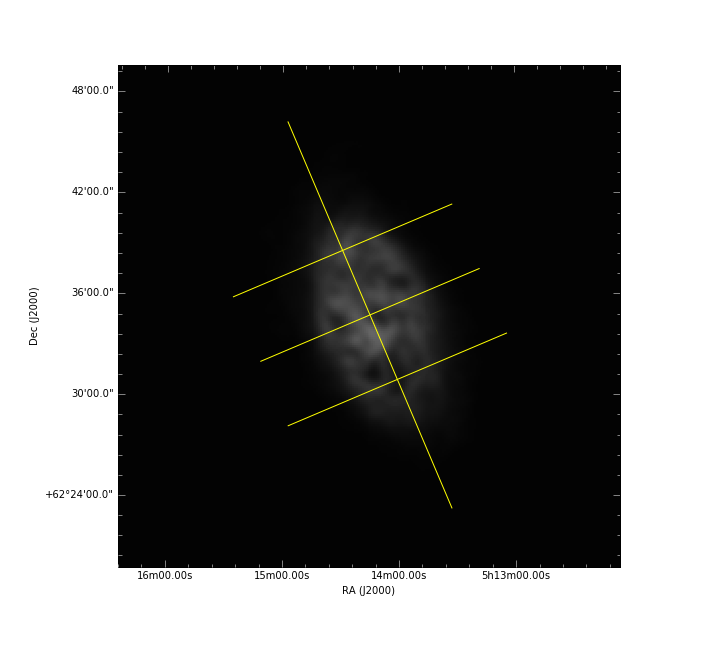

<IPython.core.display.Javascript object>


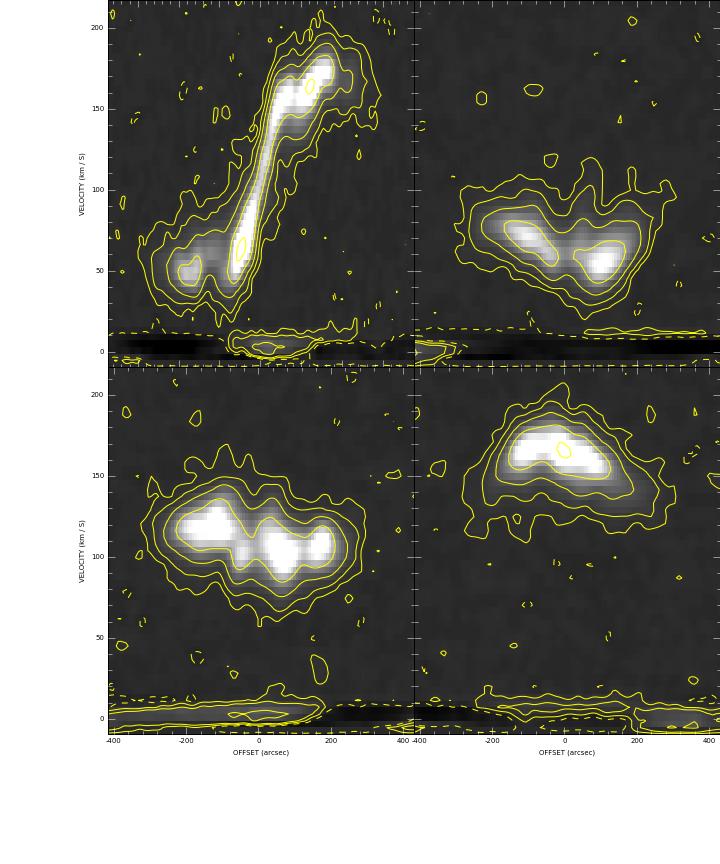

<IPython.core.display.Javascript object>


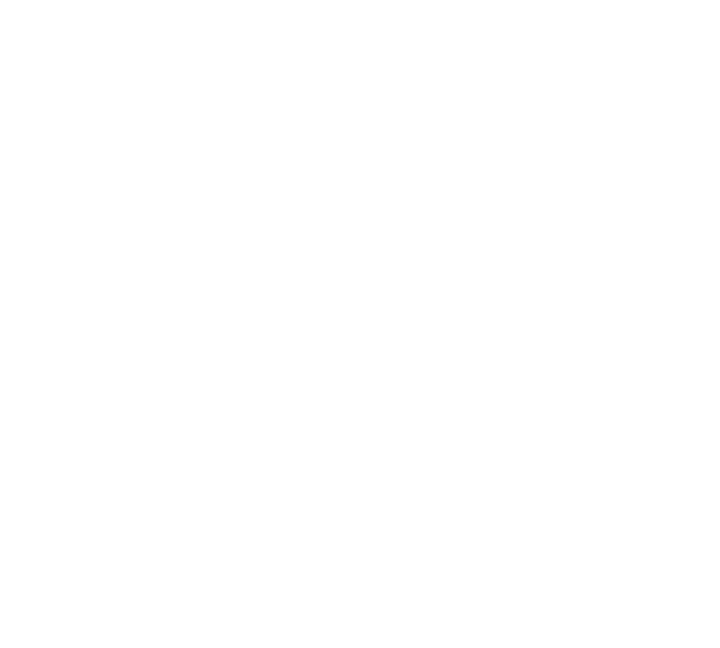

In [13]:
import astropy
import pvextractor
import matplotlib
import aplpy
import numpy as np

def pvhelper(w, hdu, centra, centdec, pa, majlen, minlen, mindist):
    """
    Helper shared between pvdiagrams and plotvlines
    """
    
    # find a list of endpoints
    
    # Find spatial pixels corresponding to position
    central_pix_x, central_pix_y = w.sub([wcs.WCSSUB_CELESTIAL]).wcs_world2pix(centra,centdec, 0)
    
    # this is how to convert arcsec to pixel
    scale_xy = hdu.header['cdelt2']*3600.

    majlen = majlen/scale_xy
    minlen = minlen/scale_xy
    mindist = mindist/scale_xy
    
    # Make a grid with origin 0, for the single cuts, in x, start cut 1, end cut 1, start cut 2, end cut 2, ...
    endpoints_y_b = np.array([majlen/2., -majlen/2.,  mindist  ,  mindist ,         0.,        0.,
                              -mindist,  -mindist])   
    # Make a grid with origin 0, for the single cuts, in y, start cut 1, end cut 1, start cut 2, end cut 2, ...
    endpoints_x_b = np.array([       0.,         0., -minlen/2., minlen/2., -minlen/2., minlen/2., 
                              -minlen/2., minlen/2.])

    # Rotate all points
    endpoints_x = endpoints_x_b*np.cos(np.pi*pa/180.)-endpoints_y_b*np.sin(np.pi*pa/180.)+central_pix_x
    endpoints_y = endpoints_x_b*np.sin(np.pi*pa/180.)+endpoints_y_b*np.cos(np.pi*pa/180.)+central_pix_y
    
    return endpoints_x, endpoints_y

def createpvdiagrams(incubus = '', outnameprefix = 'bla', centra = '30.', 
               centdec = '60.', pa = 45., majlen = 100., minlen = 10., mindist = 50.):
    """
    Produce foue PV-diagrams from incubus
    
    incubus (string)      : Input data cube
    outnameprefix (string): Prefix for 4 output PV diagrams (outnameprefix+suffix), see below
    centra (float)        : Right ascension of centre (degrees)
    centdec (float)       : Declination of centre (degrees)
    pa (float)            : Position angle (degrees)
    majlen (float)        : Length of major axis cut (arcsec)
    minlen (float)        : Length of minor axis cut (arcsec)
    mindist (float)       : Distance between centre and outer minor axis cuts (arcsec)
    
    Will produce four pv diagrams, one along the "major" axis, defined by the central coordinates 
    centra (deg), centdec (deg), position angle (pa in degrees), and length majlen in arcsec, three 
    perpendicular with respect to the major axis, one through the centre, two (at each side) at a 
    distance of mindist (in arcsec) from the centre, of the length minlen. Output PV diagrams will 
    be called outnameprefix+'_pvmaj.fits', outnameprefix+'_pvmin_cent.fits', outnameprefix+'_pvmin_left.fits', 
    outnameprefix+'_pvmin_right.fits'. Plotoutname is a plot of file overplotname together with the 
    slice positions. Position angle should be defined as the receding side major axis.
    """

    fitsobj = astropy.io.fits.open(incubus)
    hdu = fitsobj[0]
    w = astropy.wcs.WCS(hdu.header, fitsobj)
    
    # find a list of endpoints
    endpoints_x, endpoints_y = pvhelper(w, hdu, centra, centdec, pa, majlen, minlen, mindist)
     
    i = -1
    for name in ['_pvmaj.fits', '_pvmin_left.fits', '_pvmin_cent.fits', '_pvmin_right.fits']:
        i = i + 1
        endpoints = [(endpoints_x[2*i],endpoints_y[2*i]),(endpoints_x[2*i+1],endpoints_y[2*i+1])]

        # This generates a path from which the pv diagram will be drawn, see pvextractor docu
        xy = pvextractor.geometry.Path(endpoints)
        # This generates a pyfits object from the input cube which is a pv diagram, see pvextractor docu
        pv = pvextractor.extract_pv_slice(hdu, xy)

        # Change pixel to central pixel
        pixels =  pv.header['NAXIS1']
        pv.header['CRPIX1'] = pixels/2
        # 
        pv.header['CDELT1'] = pv.header['CDELT1']*3600.
        pv.header['CRVAL1'] = pv.header['CRVAL1']*3600.
        pv.header['CUNIT1'] = 'ARCSEC'
#        pv.header['CTYPE1'] = 'POSITION'
 
        # And make y axis a unit with three digits less
        pv.header['CDELT2'] = pv.header['CDELT2']/1000.
        pv.header['CRVAL2'] = pv.header['CRVAL2']/1000.
        pv.header['CUNIT2'] = 'KM/S'
        # This is just a trick to make aplpy not recognise the coordinate type, otherwise it will enforce m/s as a unit
        pv.header['CTYPE2'] = 'VELOCITY'
 
        # Write out file, delete if it already exists (that's the clobber option switched on)
        pv.writeto(outnameprefix+name, clobber = True)
    return

def plotpvlines(aplpyobj = False, pyfitsobj = False, centra = '30.', centdec = '60.', pa = 45., majlen = 100., minlen = 10., 
                mindist = 50., colour = 'red', plotoutname = ''):
    """
    Overplot lines corresponding to pv diagrams on given aplpy figure
    aplpyobj            : Open aplpy FITSFigure 
    pyfitsobj           : pyfits 
    centra (float)      : Right ascension of centre (degrees)
    centdec (float)     : Declination of centre (degrees)
    pa (float)          : Position angle (degrees)
    majlen (float)      : Length of major axis cut (arcsec)
    minlen (float)      : Length of minor axis cut (arcsec)
    mindist (float)     : Distance between centre and outer minor axis cuts (arcsec)
    color (string)      : Color of lines
    plotoutname (string): Name of output file (dummy at the moment)
 
    centra = '30.', centdec = '60.', pa = 45., majlen = 100., minlen = 10., 
                mindist = 50., color = 'red', plotoutname = ''
    
    """
    hdu = pyfitsobj[0]
    w = astropy.wcs.WCS(hdu.header, pyfitsobj)
    
    endpoints_x, endpoints_y = pvhelper(w, hdu, centra, centdec, pa, majlen, minlen, mindist)
    
    i = -1
    for name in ['_pvmaj.fits', '_pvmin_left.fits', '_pvmin_cent.fits', '_pvmin_right.fits']:
        i = i + 1
        endpoints = [(endpoints_x[2*i],endpoints_y[2*i]),(endpoints_x[2*i+1],endpoints_y[2*i+1])]
    
        # Calculate coordinates of end points again
        endpoints_wcs = w.sub([wcs.WCSSUB_CELESTIAL]).wcs_pix2world([[x,y] for x,y in endpoints], 0)
        aplpyobj.show_lines([endpoints_wcs.T],color=colour)
    
    # aplpyobj.save(plotoutname)
    return

def plotpvdiagrams(greyscaleprefix = '', color1contourprefix = '', colour1 = 'red', color2contourprefix = '', 
                   colour2 = 'blue', contours = 5, vminmax = [0., 0.01]):
    """
    Plotting four PVdiagrams as generated by createpvdiagrams
    
    greyscaleprefix (string)    : Prefix to the names of the datasets from which greyscale images will be generated
    color1contourprefix (string): Prefix to the names of the datasets from which color1 contours will be generated (ignored if empty)
    color1 (string)             : Color 1
    color2contourprefix (string): Prefix to the names of the datasets from which color2 contours will be generated (ignored if empty)
    color2 (string)             : Color 2
    contours (int or list)      : Contour levels if given as list, number of contours if given as list.
    vminmax (list)              : Minimum and maximum for greyscale wedge
    
    createpvdiagrams will generate four PV diagrams, outnameprefix+'_pvmaj.fits', outnameprefix+'_pvmin_cent.fits', 
    outnameprefix+'_pvmin_left.fits', outnameprefix+'_pvmin_right.fits'. It is assumed that the input prefixes in 
    this funtion are identical to some input in createpvdiagrams, i.e. that the following 12 data sets exist (unless 
    the input is an empty string): greyscaleprefix+'_pvmaj.fits', greyscaleprefix+'_pvmin_cent.fits', 
    greyscaleprefix+'_pvmin_left.fits', greyscaleprefix+'_pvmin_right.fits', color1contourprefix+'_pvmaj.fits', ..., 
    color2contourprefix+_pvmin_right.fits. For each PV cut (major, min_left, min_cent, min_right), a greyscale plot will
    be generated overlaid with contours.
    """
    
    nx = 2
    ny = 2
    border = 0.15
    
    # Sizes of panels in x and y
    dx = (1.0-border)/float(nx)
    dy = (1.0-border)/float(ny)
  
    fig = plt.figure(figsize=(10,12))
    greyscales = []
    for name in ['_pvmaj.fits', '_pvmin_left.fits', '_pvmin_cent.fits', '_pvmin_right.fits']:
        greyscales.append(greyscaleprefix+name)
    color1conts= []
    if color1contourprefix != '':
        for name in ['_pvmaj.fits', '_pvmin_left.fits', '_pvmin_cent.fits', '_pvmin_right.fits']:
            color1conts.append(color1contourprefix+name)
    color2conts= []
    if color2contourprefix != '':
        for name in ['_pvmaj.fits', '_pvmin_left.fits', '_pvmin_cent.fits', '_pvmin_right.fits']:
            color2conts.append(color2contourprefix+name)

    appfigs = []
    for j in range(ny):
        for i in range(nx):
            appfig = aplpy.FITSFigure(greyscales[j*nx+i], figure = fig, subplot=[border+i*dx,1.0-(j+1)*dy,dx,dy])
            appfig.show_grayscale(vmin = vminmax[0], vmax = vminmax[1], aspect = 'auto')
            if color1conts != []:
                appfig.show_contour(data = color1conts[j*nx+i], levels = contours, colors = colour1)
            if color2conts != []:
                appfig.show_contour(data = color2conts[j*nx+i], levels = contours, colors = colour2)
            if i > 0:
                appfig.hide_yaxis_label()
                appfig.hide_ytick_labels()
            if j < ny - 1:
                appfig.hide_xaxis_label()
                appfig.hide_xtick_labels()
            appfig.axis_labels.set_font(size='x-small')
            appfig.tick_labels.set_font(size='x-small')
            appfigs.append(appfig)

    plt.show()
    for i in appfigs:
        i.close()
    
if __name__ == "__main__":

    # This is the stuff we want to use to extract PV-diagrams
    cube = 'figures/UGCA105cube.fits'
    
    # This has been generated before, it is used to plot cuts on
    mom0 = 'figures/UGCA105_m0.fits'
    
    # Centre of cut
    centre_ra= 78.5620851964
    centre_dec= 62.5800017496

    # Position angle, anticlockwise from North (receding side)
    posa = 203.
    
    # Length of major axis cut
    len_maj = 1500.
    
    # Length of minor axis cuts
    len_min = 850.
    dist_min = 250.
    
    # Prefix of output PV diagram names
    outputname = 'figures/UGCA_105_pvorig'
    
    # Base contour level, number of contours and factor to multiply base contour level by
    level = 0.001
    contours = 6
    factor = 3
    
    createpvdiagrams(incubus = cube, outnameprefix = outputname, centra = centre_ra, 
               centdec = centre_dec, pa = posa, majlen = len_maj, minlen = len_min, mindist = dist_min)
    
    fitsobj = astropy.io.fits.open(mom0)
    
    aplpobj = aplpy.FITSFigure(mom0)
    aplpobj.show_grayscale(vmin=-0.1, vmax=7.5)
    matplotlib.pyplot.show()

    plotpvlines(aplpyobj = aplpobj, pyfitsobj = fitsobj, centra = centre_ra, 
               centdec = centre_dec, pa = posa, majlen = len_maj, minlen = len_min, mindist = dist_min, colour = 'yellow')
    
    contlevels = [-level]
    
    for i in range(contours-1):
        contlevels.append(level*pow(factor,i))
   
    plotpvdiagrams(greyscaleprefix = 'figures/UGCA_105_pvorig', color1contourprefix = '', 
                   color2contourprefix = 'figures/UGCA_105_pvorig', colour2 = 'yellow', contours = contlevels, 
                   vminmax = [-0.01,0.05])

#### Integrated spectra

Another data product frequently required, e.g. for the accurate determination of spectral line widths, is the integrated HI spectrum of a source, which can be extracted by summing over the spatial extent of the emission,

$$ S_{\rm int}(z) = \frac{1}{\Omega_{\rm PSF}} \sum_{x} \sum_{y} S(x, y, z) , $$

where, as in the case of the [integrated flux](#Integrated-flux-and-HI-mass), we need to divide by the solid angle of the telescope’s point spread function (measured in pixel units rather than radians). Again, a detailed source mask will be required to obtain a useful spectrum, as otherwise we might either miss flux or unnecessarily increase the statistical noise in the resulting spectrum.

A Python example for creating the integrated spectrum of a source based on a source mask is included below. As before, the example simply loops through the entire data cube to generate the spectrum; this is inefficient for large data cubes in Python, and numerical libraries such as NumPy should instead be used for arithmetic operations on data arrays.

Beam size:  15.5 x 15.5 arcmin
Pixel size: 4.0 arcmin


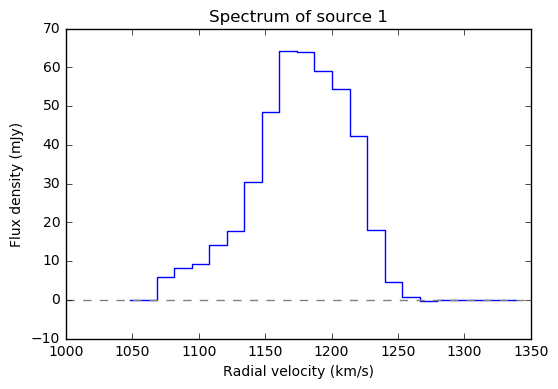

In [14]:
# Creating an integrated spectrum from a data cube
%matplotlib inline
# %matplotlib notebook 
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from math import pi, log

# Select source to be analysed
source_id = 1  # Must be 1 or 2!

# Open example FITS cube and extract WCS header keywords and data
hdulist = fits.open("figures/data_cube.fits")
wcshead = wcs.WCS(hdulist[0].header)
scidata = hdulist[0].data

# Read cube dimensions and create array for spectrum
nz, ny, nx = scidata.shape
spectrum = [0 for z in range(nz)]

# Convert channel numbers to velocity using WCS
velo = [0 for z in range(nz)]
for z in range(nz):
    equ_coords = wcshead.wcs_pix2world(0, 0, z, 0)
    velo[z] = equ_coords[2] / 1000.0 # velocity in km/s

# Read beam information from header
bmaj     = float(hdulist[0].header["bmaj"])
bmin     = float(hdulist[0].header["bmin"])
pix_size = float(hdulist[0].header["cdelt2"])
omega    = pi * bmaj * bmin / (4.0 * log(2.0) * pix_size * pix_size)
print("Beam size:  %.1f x %.1f arcmin" % (60.0 * bmaj, 60.0 * bmin))
print("Pixel size: %.1f arcmin" % (60.0 * pix_size))

# Open mask cube
hdulist2 = fits.open("figures/data_cube_mask.fits")
mask = hdulist2[0].data

# Create integrated spectrum
for z in range(nz):
    spectrum[z] = 0.0
    for y in range(ny):
        for x in range(nx):
            if mask[z][y][x] == source_id: spectrum[z] += scidata[z][y][x]
    spectrum[z] /= omega   # Correct for beam size
    spectrum[z] *= 1000.0  # Convert from Jy to mJy

# Plot integrated spectrum
plt.plot(velo, spectrum, drawstyle="steps-mid")
plt.axhline(0.0, color="grey", linestyle="dashed")
plt.xlabel("Radial velocity (km/s)")
plt.ylabel("Flux density (mJy)")
plt.title("Spectrum of source %i" % source_id)
plt.show()

### Model fitting to spectral line profiles

At a frequency of 1.4&nbsp;GHz the angular resolution of classical radio telescopes is often relatively poor and of the order of 1&nbsp;arcmin or above. Hence, more distant galaxies beyond the local volume are usually poorly resolved by HI observations, while the spectral resolution remains high enough to resolve the galaxy&rsquo;s spectral profile. In such cases it may be desirable to not parameterise the galaxy in the full, three-dimensional data cube, but rather [generate an integrated spectrum](#Integrated-spectra) of the object and then determine the galaxy’s parameters from an analysis of the one-dimensional spectral profile.

#### Fitting a Gaussian function

One of the most basic functions commonly used to fit HI spectral profiles is the Gaussian function. In its most basic form it can be written as

$$ G(z) = A \exp \left( \! -\frac{\left[ z - z_{0} \right]^{2}}{2 \, \sigma^{2}} \! \right) $$

where $A$ is the amplitude, $z_{0}$ is the centroid, and $\sigma$ is the width of the Gaussian. From the three free parameters of the fit we can immediately derive basic observational parameters of the fitted HI source. The velocity or frequency centroid is directly given by $z_{0}$, while the full width at half maximum (FWHM) of the spectral profile, $w_{50}$, is given by

$$ w_{50} = 2 \sqrt{2 \ln(2)} \, \sigma \approx 2.3548 \, \sigma . $$

Finally, the integrated flux, $S_{\rm int}$, of the source can be derived from integrating over the fitted Gaussian:

$$ S_{\rm int} = \! \int \limits_{-\infty}^{\infty} \! G(z) \, \mathrm{d}z = \sqrt{2 \pi} \, A \sigma \approx 2.5066 \, A \sigma . $$

Gaussian fitting is particularly useful for sources with simple, single-component line profiles, including dwarf galaxies, face-on galaxies and Galactic HI clouds (e.g. high-velocity clouds).

#### Fitting a Busy Function

Spiral galaxies seen at intermediate or high inclination usually possess a characteristic so-called &ldquo;double-peak&rdquo; or &ldquo;double-horn&rdquo; profile. This profile shape can be fitted and described by the so-called Busy Function, $B(z)$, where $z$ denotes the spectral coordinate, e.g. spectral channel, frequency or velocity ([<cite data-cite="2014MNRAS.438.1176W">Westmeier et al. 2014</cite>](http://adsabs.harvard.edu/abs/2014MNRAS.438.1176W)). In its most general form, the Busy Function is the product of two error functions, $\mathrm{erf}(z)$, describing the steep outer flanks of the spectrum and a polynomial to characterise the central trough:

$$ B(z) = \frac{a}{4} \times [\mathrm{erf}(b_{1} (w + z - z_{\rm e})) + 1] \times [\mathrm{erf}(b_{2} (w - z + z_{\rm e})) + 1] \times \left[ c \, \left| z - z_{\rm p} \right|^{\,n} + 1 \right] . $$

The eight free parameters of the Busy Function are:

* $a$ – Amplitude of the function.
* $b_{1}$, $b_{2}$ – These two parameters control the steepness of spectrum&rsquo;s outer flanks. A larger value of $b_{x}$ results in a steeper flank.
* $c$ – Amplitude of the polynomial trough.
* $n$ – Degree of the polynomial trough. A larger value of $n$ will result in a broader trough with steeper flanks.
* $w$ – This parameter corresponds to half the width of the profile, i.e. the separation between the two error functions is equal to $2w$.
* $z_{\rm e}$, $z_{\rm p}$ – Centroid of the two error functions and the polynomial trough, respectively. By choosing $z_{\rm e} \ne z_{\rm p}$ one can shift the trough with respect to the error functions and thus create an asymmetric line profile.

The Busy Function is flexible enough to describe a wide range of symmetric and asymmetric spectral profiles commonly found in galaxies, from simple single-component profiles (Gaussian, top-hat, etc.) to complex, asymmetric double-horn profiles. A Python implementation of the Busy Function that uses the error function provided by SciPy is shown below. The reader is encouraged to experiment with different input parameter settings to explore their impact on the overall shape of the Busy Function.

In [ ]:
# Plotting the Busy Function
%matplotlib notebook
import numpy
import matplotlib.pyplot as plt
from scipy.special import erf

# Parameter settings
a  = 1.0
b1 = 0.2
b2 = 0.1
c  = 0.0005
n  = 2.0
w  = 50.0
ze = 0.0
zp = 5.0

# Calculation of B(z)
z  = numpy.linspace(-100, 100, 201)
bf = (a / 4.0) * (erf(b1 * (w + z - ze)) + 1.0) * (erf(b2 * (w - z + ze)) + 1.0) * (c * pow(abs(z - zp), n) + 1.0)

# Plotting of B(z)
plt.plot(z, bf)
plt.xlabel("z")
plt.ylabel("B(z)")
plt.show()

As the Busy Function is a heuristic function, the up to eight free parameters of the function have no immediate physical meaning, but instead need to be converted into more meaningful galaxy parameters, e.g. the integrated flux, systemic velocity or profile width. Unfortunately, the Busy Function is too complex for such parameters to be calculated analytically, and numerical calculation of physical parameters is thus required. For example, the integrated flux of a galaxy can be determined by numerically integrating over the fitted Busy Function.

As the Busy Function is a simple analytic function, any data analysis software can be used to fit a Busy Function to spectral profiles, including the Python package [LMFIT](https://lmfit.github.io/lmfit-py/) or the stand-alone software [QtiPlot](http://www.qtiplot.com/). In addition, two Busy Function fitting routines specifically developed for HI spectral-line fitting are available: [BF_dist](https://github.com/RussellJurek/busy-function-fitting/) and [BusyFit](http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_software_busyfit.php).

#### Alternative models for double-horn profiles

Another option for describing the double-horn profile of galaxies is to model the outer flanks and the central trough of the spectrum separately. A common approach is to use Gaussian functions for the flanks and a polynomial for the trough:

$$ S(z) = \begin{cases}
a_{\rm G} \exp \left( \! -\frac{[z - (z_{0} - w)]^{2}}{2 \sigma^{2}} \! \right) & \text{if } z < z_{0} - w \\
a_{\rm C} + \frac{a_{\rm G} - a_{\rm C}}{w^{2}} (z - z_{0})^{2} & \text{if } z_{0} - w \le z \le z_{0} + w \\
a_{\rm G} \exp \left( \! -\frac{[z - (z_{0} + w)]^{2}}{2 \sigma^{2}} \! \right) & \text{if } z > z_{0} + w \\
\end{cases} $$

(e.g. [<cite data-cite="1607.01393">Tiley et al. 2016</cite>](http://arxiv.org/abs/1607.01393/)). An advantage of this approach is that the generally sharp peaks of HI profiles are more accurately modelled, although the function is not differentiable at the position where the Gaussian and polynomial join.

### Systematic biases in source parameterisation

HI data cubes not only contain signal from the sources we intend to study, but also statistical noise. This noise limits the accuracy with which we can extract observational and physical parameters of sources in the data cube and hence determines the statistical uncertainty of our measurement. However, the presence of noise can also result in systematic errors and biases in some of the measured parameters. These biases can be roughly divided into two categories:

1. Biases caused by the source finding threshold.
2. Biases created by the presence of noise.

This section describes the most common biases in source parameterisation and explores methods to reduce or avoid them.

#### Source finding threshold

Most source finding algorithms are based on extracting emission above a user-defined flux threshold. The problem with this approach, however, is that those parts of a source that fall below the flux threshold, e.g. the outer HI disc of a galaxy, will be excluded from the source mask and thus the measurement of source parameters. The most obvious effect created by this type of bias is that of **missing flux** in the integrated flux measurement. This is illustrated in the figure below from [<cite data-cite="2012PASA...29..276W">Westmeier et al. (2012)</cite>](http://adsabs.harvard.edu/abs/2012PASA...29..276W), which shows the ratio of measured versus true integrated flux as a function of signal-to-noise ratio for a set of point source models with Gaussian spectral line profiles. Due to the finite detection threshold, integrated flux measurements are systematically too low, in particular at the lower end of the flux density range, as the faint outer parts of the source images (after convolution with a telescope beam) are excluded from the source mask.

<figure>
    <img src="figures/int_flux_bias.png" width="640" height="434" alt="Integrated flux bias" \>
    <figcaption>*Ratio of measured versus true integrated flux as a function of peak signal-to-noise ratio for a set of point source models with Gaussian spectral line profiles. Due to the finite detection threshold, integrated flux measurements are systematically too low, in particular at the lower end of the flux density range. The image was taken from [<cite data-cite="2012PASA...29..276W">Westmeier et al. (2012)</cite>](http://adsabs.harvard.edu/abs/2012PASA...29..276W).*</figcaption>
</figure>

A simple script that analytically calculates and plots the expected integrated flux error for a one-dimensional source of Gaussian shape is included below. This situation applies when, e.g., an HI spectrum is searched for emission or absorption lines, but the concept can easily be expanded to two-dimensional or three-dimensional sources of Gaussian or other shape. In the one-dimensional example below, the typical flux measurement of a source with a peak flux density of 3&nbsp;&times; the flux threshold is about 14% too low, while for a source of 2&nbsp;&times; the flux threshold the defect already increases to 24%.

In [ ]:
# Simulating biases in integrated flux measurements
%matplotlib notebook
import matplotlib.pyplot as plt
from numpy import linspace, sqrt, log, exp
from scipy.special import erf
from math import pi

# Input
snr = 3.0   # Ratio of peak flux to flux threshold, must be >= 1.0

# Calculate boundary and integrals over Gaussian
x = sqrt(-2.0 * log(1.0 / snr))
int_full = sqrt(2.0 * pi)
int_part = -sqrt(pi / 2.0) * (erf(-x / sqrt(2.0)) - erf(x / sqrt(2.0)))

# Calculate missing flux from ratio of integrals
flux_error = 100.0 * (1.0 - int_part / int_full)

# Generate plot
z = linspace(-4, 4, 201)
gauss = exp(-z*z / 2.0)
plt.fill_between(z, gauss, color="lavender")
plt.plot(z, gauss, color="black")
plt.axhline(1.0 / snr, color="blue", linestyle="dashed")
plt.axvline(-x, color="red")
plt.axvline(x, color="red")
plt.xlabel("x")
plt.ylabel("G(x)")
plt.text(-3.8, 1.0 / snr + 0.015, "flux threshold", color="blue")
plt.text(-(x / 2.0) - 2.0, 1.0 / (2.0 * snr) - 0.015, "missing flux", color="red", horizontalalignment="center")
plt.text( (x / 2.0) + 2.0, 1.0 / (2.0 * snr) - 0.015, "missing flux", color="red", horizontalalignment="center")
plt.text(0.0, 1.0 / (2.0 * snr) - 0.015, "measured flux", color="green", horizontalalignment="center")
plt.text(-3.8, 0.94, "Flux defect: %.1f%%" % flux_error, color="black")
plt.show()

There are several ways to mitigate the systematic bias in source parameterisation caused by a finite detection threshold. One method, which has been implemented in the [Duchamp](http://www.atnf.csiro.au/people/Matthew.Whiting/Duchamp/) source finder, is to apply a secondary **growth threshold**. The source finder is first run with a regular flux threshold (e.g. 3&sigma;) to generate a catalogue of sources above that threshold. In a second step, the mask of each source is then grown by adding neighbouring pixels above a second, slightly lower threshold (e.g. 2&sigma;). This ensures that low-level emission is included in the source mask without increasing the number of false detections in the catalogue (as would be case if a lower flux threshold had been applied right from the start).

While applying a growth threshold can improve the source mask and decrease the resulting parameterisation errors, a small systematic error will remain, as the growth threshold, too, will need to be finite. An improved method of source **mask optimisation** has therefore been developed for the [SoFiA](https://github.com/SoFiA-Admin/SoFiA/) source finder. The basic concept of mask optimisation is to iteratively expand the initial source mask produced by a threshold finder until the integrated flux within the mask does not increase any further. This ensures that the final mask encompasses the entire source, thereby minimising parameterisation biases. Different methods can be used to grow masks, including the use of simple elliptical masks of increasing size or the dilation of initial source masks with a specific shape.

#### Impact of noise

In addition to a finite detection threshold, the presence of noise in a data cube can also result in systematic errors in the measurement of certain source parameters. One of the most strongly affected parameters is the **peak flux density** of a source. It is often determined by simply picking the largest value encountered within the source mask. In this case, however, there is a high probability that the value is systematically elevated by the presence of noise peaks superposed on the source emission. The effect is clearly visible in the figure below from [<cite data-cite="2012PASA...29..276W">Westmeier et al. (2012)</cite>](http://adsabs.harvard.edu/abs/2012PASA...29..276W), which shows the ratio of measured versus true peak flux density of a set of point source models with Gaussian spectral line profiles. The average peak flux density measurement is too high in all bins of the plot and increases significantly for faint sources below a signal-to-noise ratio of about&nbsp;5.

<figure>
    <img src="figures/peak_flux_bias.png" width="640" height="442" alt="Peak flux bias" \>
    <figcaption>*Ratio of measured versus true peak flux density as a function of peak signal-to-noise ratio for a set of point source models with Gaussian spectral line profiles. A systematic bias is clearly visible, increasing drastically below about 5&sigma;. The image was taken from [<cite data-cite="2012PASA...29..276W">Westmeier et al. (2012)</cite>](http://adsabs.harvard.edu/abs/2012PASA...29..276W).*</figcaption>
</figure>

The bias in the peak flux density measurement is further elevated by an additional selection effect: sources just below the detection threshold might get pushed above the threshold by superposed noise peaks. Hence, sources at the faint end of the flux density range are even more likely to yield a peak flux density measurement that is systematically too high.

In addition to peak flux density, other parameters might be affected by the noise as well, although to a lesser degree. This is the case, e.g., for line width measurements, in particular close to the noise level. A general solution to the issue of noise-related biases is the **fitting of source models** and extraction of source parameters from the fit. This will ensure that statistical noise does not enter into the measurement of observational parameters in the first place, but instead solely controls the statistical uncertainty of the measurements.

### Correction factors at higher redshift

In all of our calculations so far we have made the fundamental assumption that the source is located in the nearby universe at redshift zero. For sources at higher redshift, corrections will need to be applied to all source parameters.

#### Velocity width

One of the most fundamental corrections applies to the velocity resolution of the data. HI data cubes usually have a channel width, $\Delta f$, that is constant in frequency. However, a constant frequency width does not translate into a constant velocity width, and the velocity resolution of a data cube therefore deteriorates with increasing redshift, with $\Delta v = (1 + Z) \, \Delta v_{0}$ (see [<cite data-cite="2014MNRAS.442.1117D">Davis &amp; Scrimgeour 2014</cite>](http://adsabs.harvard.edu/abs/2014MNRAS.442.1117D)), where $\Delta v_{0}$ is the velocity resolution at $Z = 0$. Therefore, a $(1 + Z)$ scaling factor will need to be applied to all velocity widths, e.g. $w_{50}$ and $w_{20}$ line widths, of sources beyond redshift zero. Velocity correction factors will also need to be applied to any other source parameters that have a dependence on velocity, for example integrated flux in units of Jy&#8239;km&#8239;s<sup>−1</sup>.

The algorithm below calculates the velocity resolution of a telescope for a given frequency resolution and observing frequency. It also plots velocity resolution as a function of frequency in the range of $f = 700 \ldots 1400~\mathrm{MHz}$ (redshift range of $Z = 0 \ldots 1$ for HI observations). In addition to the correct $(1 + Z)$ scaling factor (blue curve), the solution for the relativistic Doppler effect (red curve) is shown in order to illustrate that the treatment of redshifts as caused by relativistic recession velocities will lead to wrong and non-sensical results beyond $Z \approx 0.03$.

In [ ]:
# Calculating velocity resolution as a function of redshift
%matplotlib notebook
import matplotlib.pyplot as plt
from numpy import linspace

# Function to convert frequency to redshift
def f2z(frequency):
    return (f0 / frequency) - 1.0

# Function to convert redshift to frequency
def z2f(redshift):
    return f0 / (redshift + 1.0)

# Function to convert redshift resolution to velocity resolution at given redshift
def dz2dv(delta_z, redshift):
    return c * delta_z / (1 + redshift)

# Input parameters
c  = 299792.458   # km/s, speed of light
f0 = 1420.40575   # MHz,  HI rest frequency
f  = 1200.0       # MHz,  observing frequency
df = 0.0185       # MHz,  frequency resolution of telescope

# Calculate redshift and velocity resolution
z  = f2z(f)
dv = dz2dv(f2z(f) - f2z(f + df), z)

# Print result
print("Velocity resolution: dv = %.2f km/s at Z = %.3f" % (dv, z))

# Plot velocity resolution curve
f     = linspace(f0 / 2.0, f0, 201)
# Correct cosmological transformation (where f0 / f = 1 + z):
dv    = dz2dv(f2z(f0) - f2z(f0 + df), 0.0) * f0 / f
plt.plot(f, dv, color="blue")
plt.text(850.0, 6.6, "1 + Z", color="blue")
# Wrong transformation using special relativity:
dv_sr = c * (((f0 * f0 - (f - df) * (f - df)) / (f0 * f0 + (f - df) * (f - df))) - ((f0 * f0 - f * f) / (f0 * f0 + f * f)))
plt.plot(f, dv_sr, color="red", linestyle="dashed")
plt.text(800.0, 5.15, "SR", color="red")
# Add redshift markers:
plt.axvline(z2f(0.0), color="grey", linestyle="dotted")
plt.axvline(z2f(0.1), color="grey", linestyle="dotted")
plt.axvline(z2f(0.2), color="grey", linestyle="dotted")
plt.axvline(z2f(0.5), color="grey", linestyle="dotted")
plt.axvline(z2f(1.0), color="grey", linestyle="dotted")
plt.text(z2f(0.0), 3.6, " 0.0", color="grey")
plt.text(z2f(0.1), 3.6, " 0.1", color="grey")
plt.text(z2f(0.2), 3.6, " 0.2", color="grey")
plt.text(z2f(0.5), 3.6, " 0.5", color="grey")
plt.text(z2f(1.0), 3.6, " Z = 1.0", color="grey")
# Add axis labels:
plt.xlabel("Frequency (MHz)")
plt.ylabel("dv (km/s)")
plt.show()

#### Further information

A detailed introduction to the correct handling of HI source parameters at higher redshift will be published by <span style="background-color:red;">Meyer et al. (in prep.)</span>. The correction factors derived in that paper have been used as the basis for a publicly available online calculator (<span style="background-color:red;">http://TBD</span>) that can be used to convert between a large range of source parameters in different reference systems and units.

### Determination of uncertanties

#### Statistical uncertainties

So far, we have only been dealing with the calculation of observational and physical parameters of HI sources. However, for a meaningful interpretation of our results we additional require knowledge of the statistical uncertainties of our measurements. Unfortunately, determination of statistical uncertainties is often hampered by several issues. One of these issues is the inherent problem that the error of a measurement based on HI data is usually by far dominated by systematic effects rather than statistical errors. Such systematic effects include

* flux calibration issues,
* continuum subtraction issues,
* errors in spectral bandpass subtraction,
* radio frequency interference,
* missing diffuse flux (due to lack of short spacings),
* parameterisation errors due to insufficient source mask,
* systematic errors in source distance measurements,
* etc.

The result of these effects is that the actual error of a measurement, e.g. integrated flux of a galaxy, is substantially larger than the calculated statistical uncertainty would suggest. As an example, let us consider a simple point source that extends across $N = 50$ spectral channels and has a constant flux density of $S = 1~\mathrm{Jy}$ in each channel with a statistical rms noise level of $\sigma = 0.1~\mathrm{Jy}$. Let us further assume that there is a systematic flux calibration error of 5% ($e_{\rm cal} = 1.05$) and a constant flux offset of $e_{\rm bp} = 1 \sigma = 0.1~\mathrm{Jy}$ in each channel due to inaccurate bandpass subtraction. The measured total flux of the source is then given by

$$ S_{\rm tot} = N \times (S + e_{\rm bp}) \times e_{\rm cal} = 57.75~\mathrm{Jy}$$

while the actual total flux of the source is $N \times S = 50~\mathrm{Jy}$. Hence, the measured flux is $7.75~\mathrm{Jy}$, or $15.5\%$, too high. Furthermore, the statistical uncertainty of the measurement is only $\sqrt{N} \times \sigma = 0.7~\mathrm{Jy}$, and hence the actual measurement error is almost eleven times as large as the derived statistical uncertainty! This basic example illustrates how summation over a large number of pixels minimises the relative statistical uncertainty of a measurement, but at the same time drastically elevates the impact of any systematic errors on the result, as their contribution always acts in the same direction. As a result, the derived statistical uncertainty of the measurement is not representative of the actual measurement error, and quoting the statistical uncertainty in a publication would therefore be grossly misleading.

#### Determination of meaningful uncertainties

In order to determine meaningful uncertainties that incorporate both statistical and systematic components, we need to apply numerical methods such as <a href="https://en.wikipedia.org/wiki/Monte_Carlo_method">Monte Carlo experiments</a>, <a href="https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29">bootstrapping</a> or <a href="https://en.wikipedia.org/wiki/Jackknife_resampling">jackknifing</a>. An approach often followed in previous HI surveys is the injection of a large number of **artificial sources** into empty sections of the data at an early stage of the data reduction process. These sources will then be calibrated and analysed in the same way as genuine astronomical sources. Comparison of the measured parameters of the artificial sources with their original ones will inform on the combined statistical and systematic errors introduced by the data reduction procedure.

Instead of injecting artificial sources into the data, a somewhat simpler approach would be to randomly **shift the source mask** to a large number of empty regions of the data cube and repeat the measurement in each case. As in the previous case, the variation of the resulting measurements will provide information on the combined statistical and systematic errors. While this method avoids the complexity of generating fake sources, it can only be used for a limited number of source parameters, in particular integrated flux measurements which simply require summation of all pixels in the mask. The uncertainties of more complex parameters, such as spectral line widths, can not be recovered with this method, as there is no analysable signal in the shifted masks.

Another complication arises from the fact that the distribution of errors derived through one of the numerical methods discussed above may not be Gaussian any more, in particular in the presence of strong systematic errors. Hence, the standard deviation of the derived values may no longer be a meaningful parameter to represent the uncertainty of the measurement, as the exact shape of the distribution can no longer be recovered from the standard deviation alone. In such cases, full multi-dimensional error distribution plots (or low-dimensional projections thereof) will need to be disseminated in order to characterise measurement uncertainties. An example of a non-Gaussian error distribution, here of the Busy Function parameter $b_{1}$, can be seen in the right-hand panel of the figure below.

<figure>
    <img src="figures/error_analysis.png" with="1200" height="406" alt="Example of error analysis for the Busy Function" />
    <figcaption style="font-style:italic;">Example of the distribution of the Busy Function parameters $a$ and $b_{1}$ (black data points) derived from fitting the Busy Function to 10,000 realisations of the integrated spectrum of the galaxy NGC&nbsp;3351 with artificial Gaussian noise added to the data (from [<cite data-cite="2014MNRAS.438.1176W">Westmeier et al. 2014</cite>](http://adsabs.harvard.edu/abs/2014MNRAS.438.1176W)). The red curve shows a Gaussian fit to the distribution. Note that the error distribution for the parameter $b_{1}$ is non-Gaussian and can no longer be expressed in a meaningful way by simply stating the standard deviation.</figcaption>
</figure>

### List of commonly used symbols

* $a$ – major axis
* $b$ – minor axis / Galactic latitude
* $\mathrm{c}$ – speed of light
* $d$ – distance
* $f$ – frequency
* $\mathrm{k_{B}}$ – Boltzmann constant
* $l$ – Galactic longitude
* $M$ – mass / moment
* $N$ – column density
* $\vec{p} = (x, y, z)$ – position in three-dimensional data cube in pixels
* $S$ – flux density
* $T$ – temperature
* $v$ – velocity
* $w$ – line width
* $Z$ – redshift
* $\alpha$ – right ascension / longitude
* $\beta$ – latitude
* $\delta$ – declination
* $\theta$ – beam angular size
* $\lambda$ – wavelength
* $\pi$ – Archimedes’ constant
* $\sigma$ – standard deviation
* $\phi$ – position angle
* $\Omega$ – solid angle

In [15]:
# Clean up
if os.path.exists('figures/UGCA105_m0.fits'): os.remove('figures/UGCA105_m0.fits') 
if os.path.exists('figures/UGCA105_m1.fits'): os.remove('figures/UGCA105_m1.fits') 
if os.path.exists('figures/UGCA105_m2.fits'): os.remove('figures/UGCA105_m2.fits') 
if os.path.exists('figures/UGCA105_mask.fits'): os.remove('figures/UGCA105_mask.fits') 
if os.path.exists('figures/UGCA105_peak.fits'): os.remove('figures/UGCA105_peak.fits') 
if os.path.exists('figures/UGCA_105_pvorig_pvmaj.fits'): os.remove('figures/UGCA_105_pvorig_pvmaj.fits') 
if os.path.exists('figures/UGCA_105_pvorig_pvmin_cent.fits'): os.remove('figures/UGCA_105_pvorig_pvmin_cent.fits') 
if os.path.exists('figures/UGCA_105_pvorig_pvmin_left.fits'): os.remove('figures/UGCA_105_pvorig_pvmin_left.fits') 
if os.path.exists('figures/UGCA_105_pvorig_pvmin_right.fits'): os.remove('figures/UGCA_105_pvorig_pvmin_right.fits')